In [15]:
import numpy as np
import scanpy as sc
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import scarches
from scarches.dataset import remove_sparsity
from lataq.models import EMBEDCVAE, TRANVAE

sc.settings.set_figure_params(dpi=600, frameon=False)
sc.set_figure_params(dpi=600)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create reference data without Delta cells and query data with Delta cells

In [3]:
adata = sc.read(
    f'../data/pancreas.h5ad'
)
adata

AnnData object with n_obs × n_vars = 16382 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score'
    obsm: 'X_seurat', 'X_symphony'

In [4]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [5]:
condition_key = "study"
cell_type_keys = ["cell_type"]
remove_cts = ["beta"]
reference = ["inDrop1", 
             "inDrop2", 
             "inDrop3", 
             "inDrop4", 
             "fluidigmc1", 
             "smartseq2", 
             "smarter"]
query = ["celseq", 
         "celseq2"]

In [196]:
adata_latent.uns['cell_type_pred_colors']

['#1f77b4',
 '#ff7f0e',
 '#279e68',
 '#d62728',
 '#aa40fc',
 '#8c564b',
 '#e377c2',
 '#b5bd61',
 '#17becf',
 '#aec7e8',
 '#ffbb78',
 '#98df8a',
 '#ff9896',
 '#c5b0d5']

In [199]:
adata_latent.obs['study'].unique()

['fluidigmc1', 'inDrop1', 'inDrop2', 'inDrop3', 'inDrop4', 'smarter', 'smartseq2', 'celseq', 'celseq2']
Categories (9, object): ['fluidigmc1', 'inDrop1', 'inDrop2', 'inDrop3', ..., 'smarter', 'smartseq2', 'celseq', 'celseq2']

In [200]:
palette_ct = {
    'acinar': '#1f77b4',
    'activated_stellate': '#ff7f0e',
    'alpha': '#279e68',
    'delta': '#d62728',
    'ductal': '#aa40fc',
    'endothelial': '#8c564b',
    'epsilon':'#e377c2',
    'gamma': '#b5bd61',
    'macrophage': '#17becf',
    'mast': '#aec7e8',
    'quiescent_stellate': '#ffbb78',
    'schwann': '#98df8a',
    't_cell': '#ff9896',
    'unknown': '#c5b0d5'
}

palette_study = {
    'fluidigmc1': '#1f77b4',
    'inDrop1': '#ff7f0e',
    'inDrop2': '#279e68',
    'inDrop3': '#d62728',
    'inDrop4': '#aa40fc',
    'smarter': '#8c564b',
    'smartseq2': '#e377c2',
    'celseq': '#b5bd61',
    'celseq2': '#17becf'
}

In [10]:
cell_type_key = cell_type_keys[-1]
adata = remove_sparsity(adata)
ref_adata = adata[adata.obs.study.isin(reference)].copy()
ref_adata = ref_adata[~ref_adata.obs.cell_type.isin(remove_cts)].copy()
query_adata = adata[adata.obs.study.isin(query)].copy()
adata = ref_adata.concatenate(query_adata)
adata.obs['query'] = adata.obs.study.isin(query)
adata.obs['query'] = adata.obs['query'].astype('category')

In [190]:
adata_plot = ref_adata.copy()
sc.pp.normalize_total(adata_plot)
sc.pp.log1p(adata_plot)
sc.pp.pca(adata_plot)
sc.pp.neighbors(adata_plot)
sc.tl.umap(adata_plot)

... storing 'study' as categorical
... storing 'cell_type' as categorical
... storing 'pred_label' as categorical


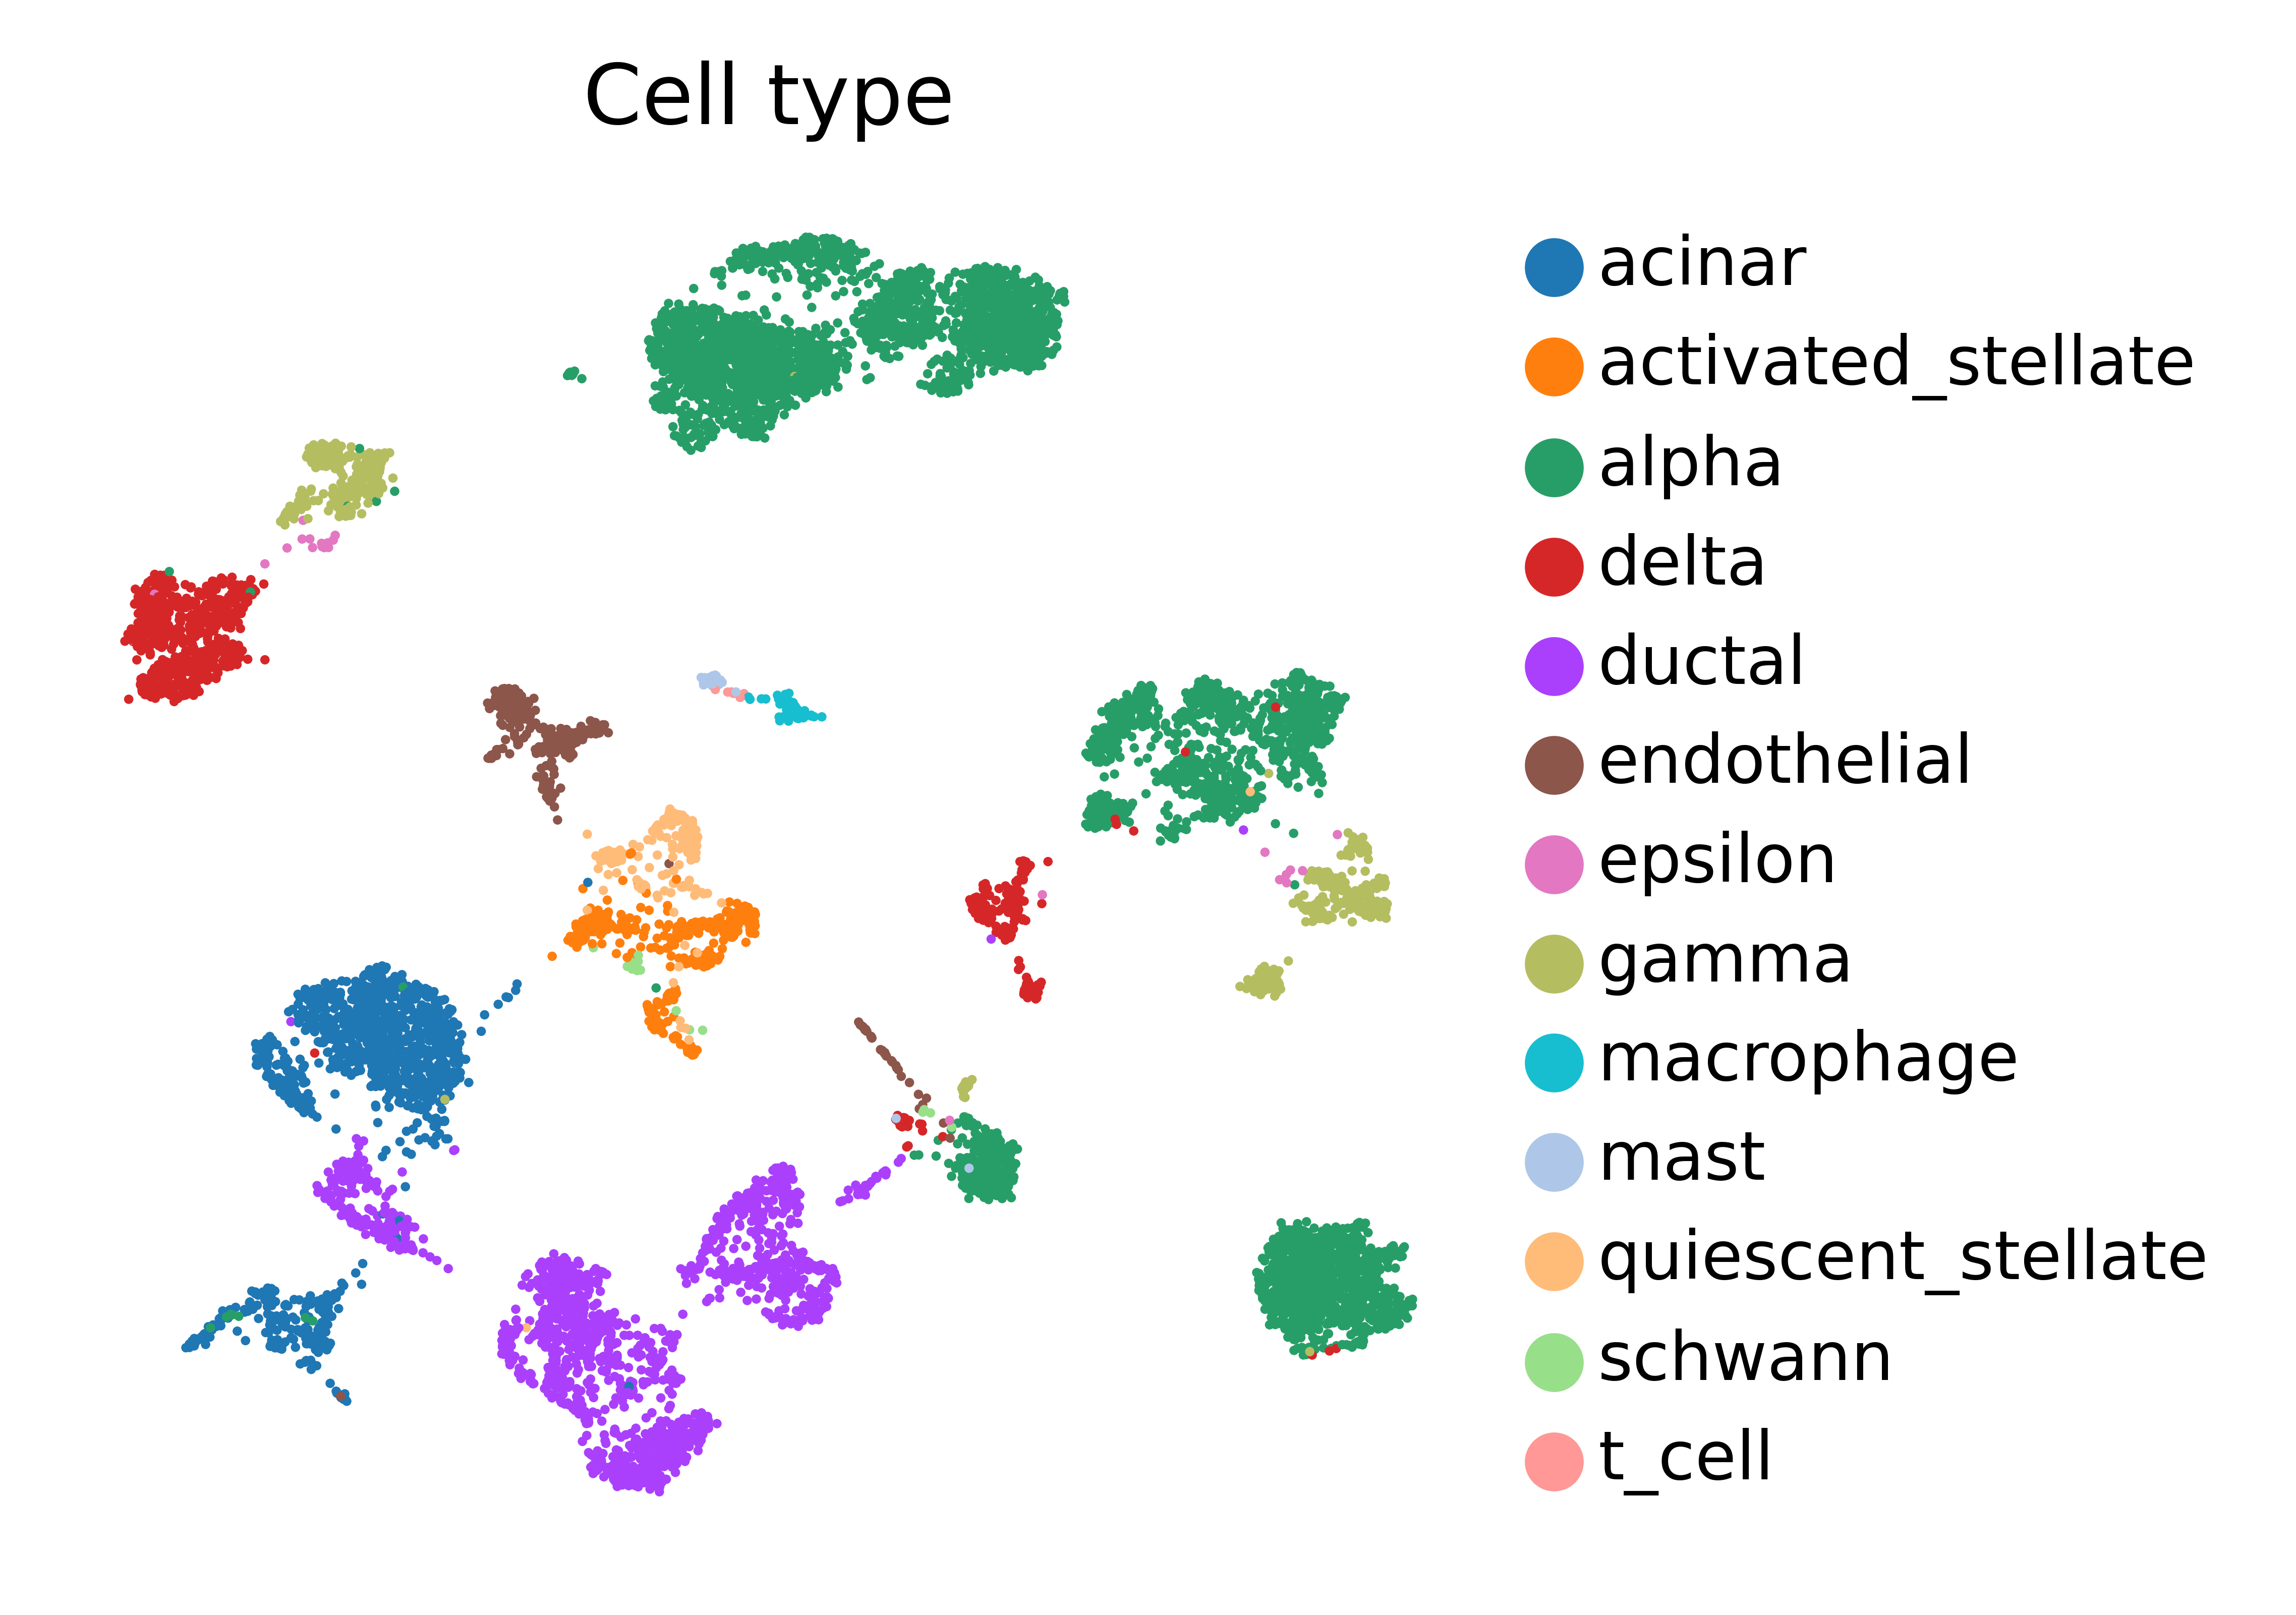

In [191]:
plt.rcParams['legend.fontsize'] = 8
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(adata_plot, color='cell_type', size=5, frameon=False, show=False, ax=ax, alpha=1)
ax.set_title('Cell type', fontsize=10)
fig.savefig('figure1/umap_ct.png', dpi=600, bbox_inches='tight')
#sc.pl.umap(adata_plot[adata_plot.obs['cell_type']=='beta'], size=15, color='cell_type', frameon=False, show=False, ax=ax)

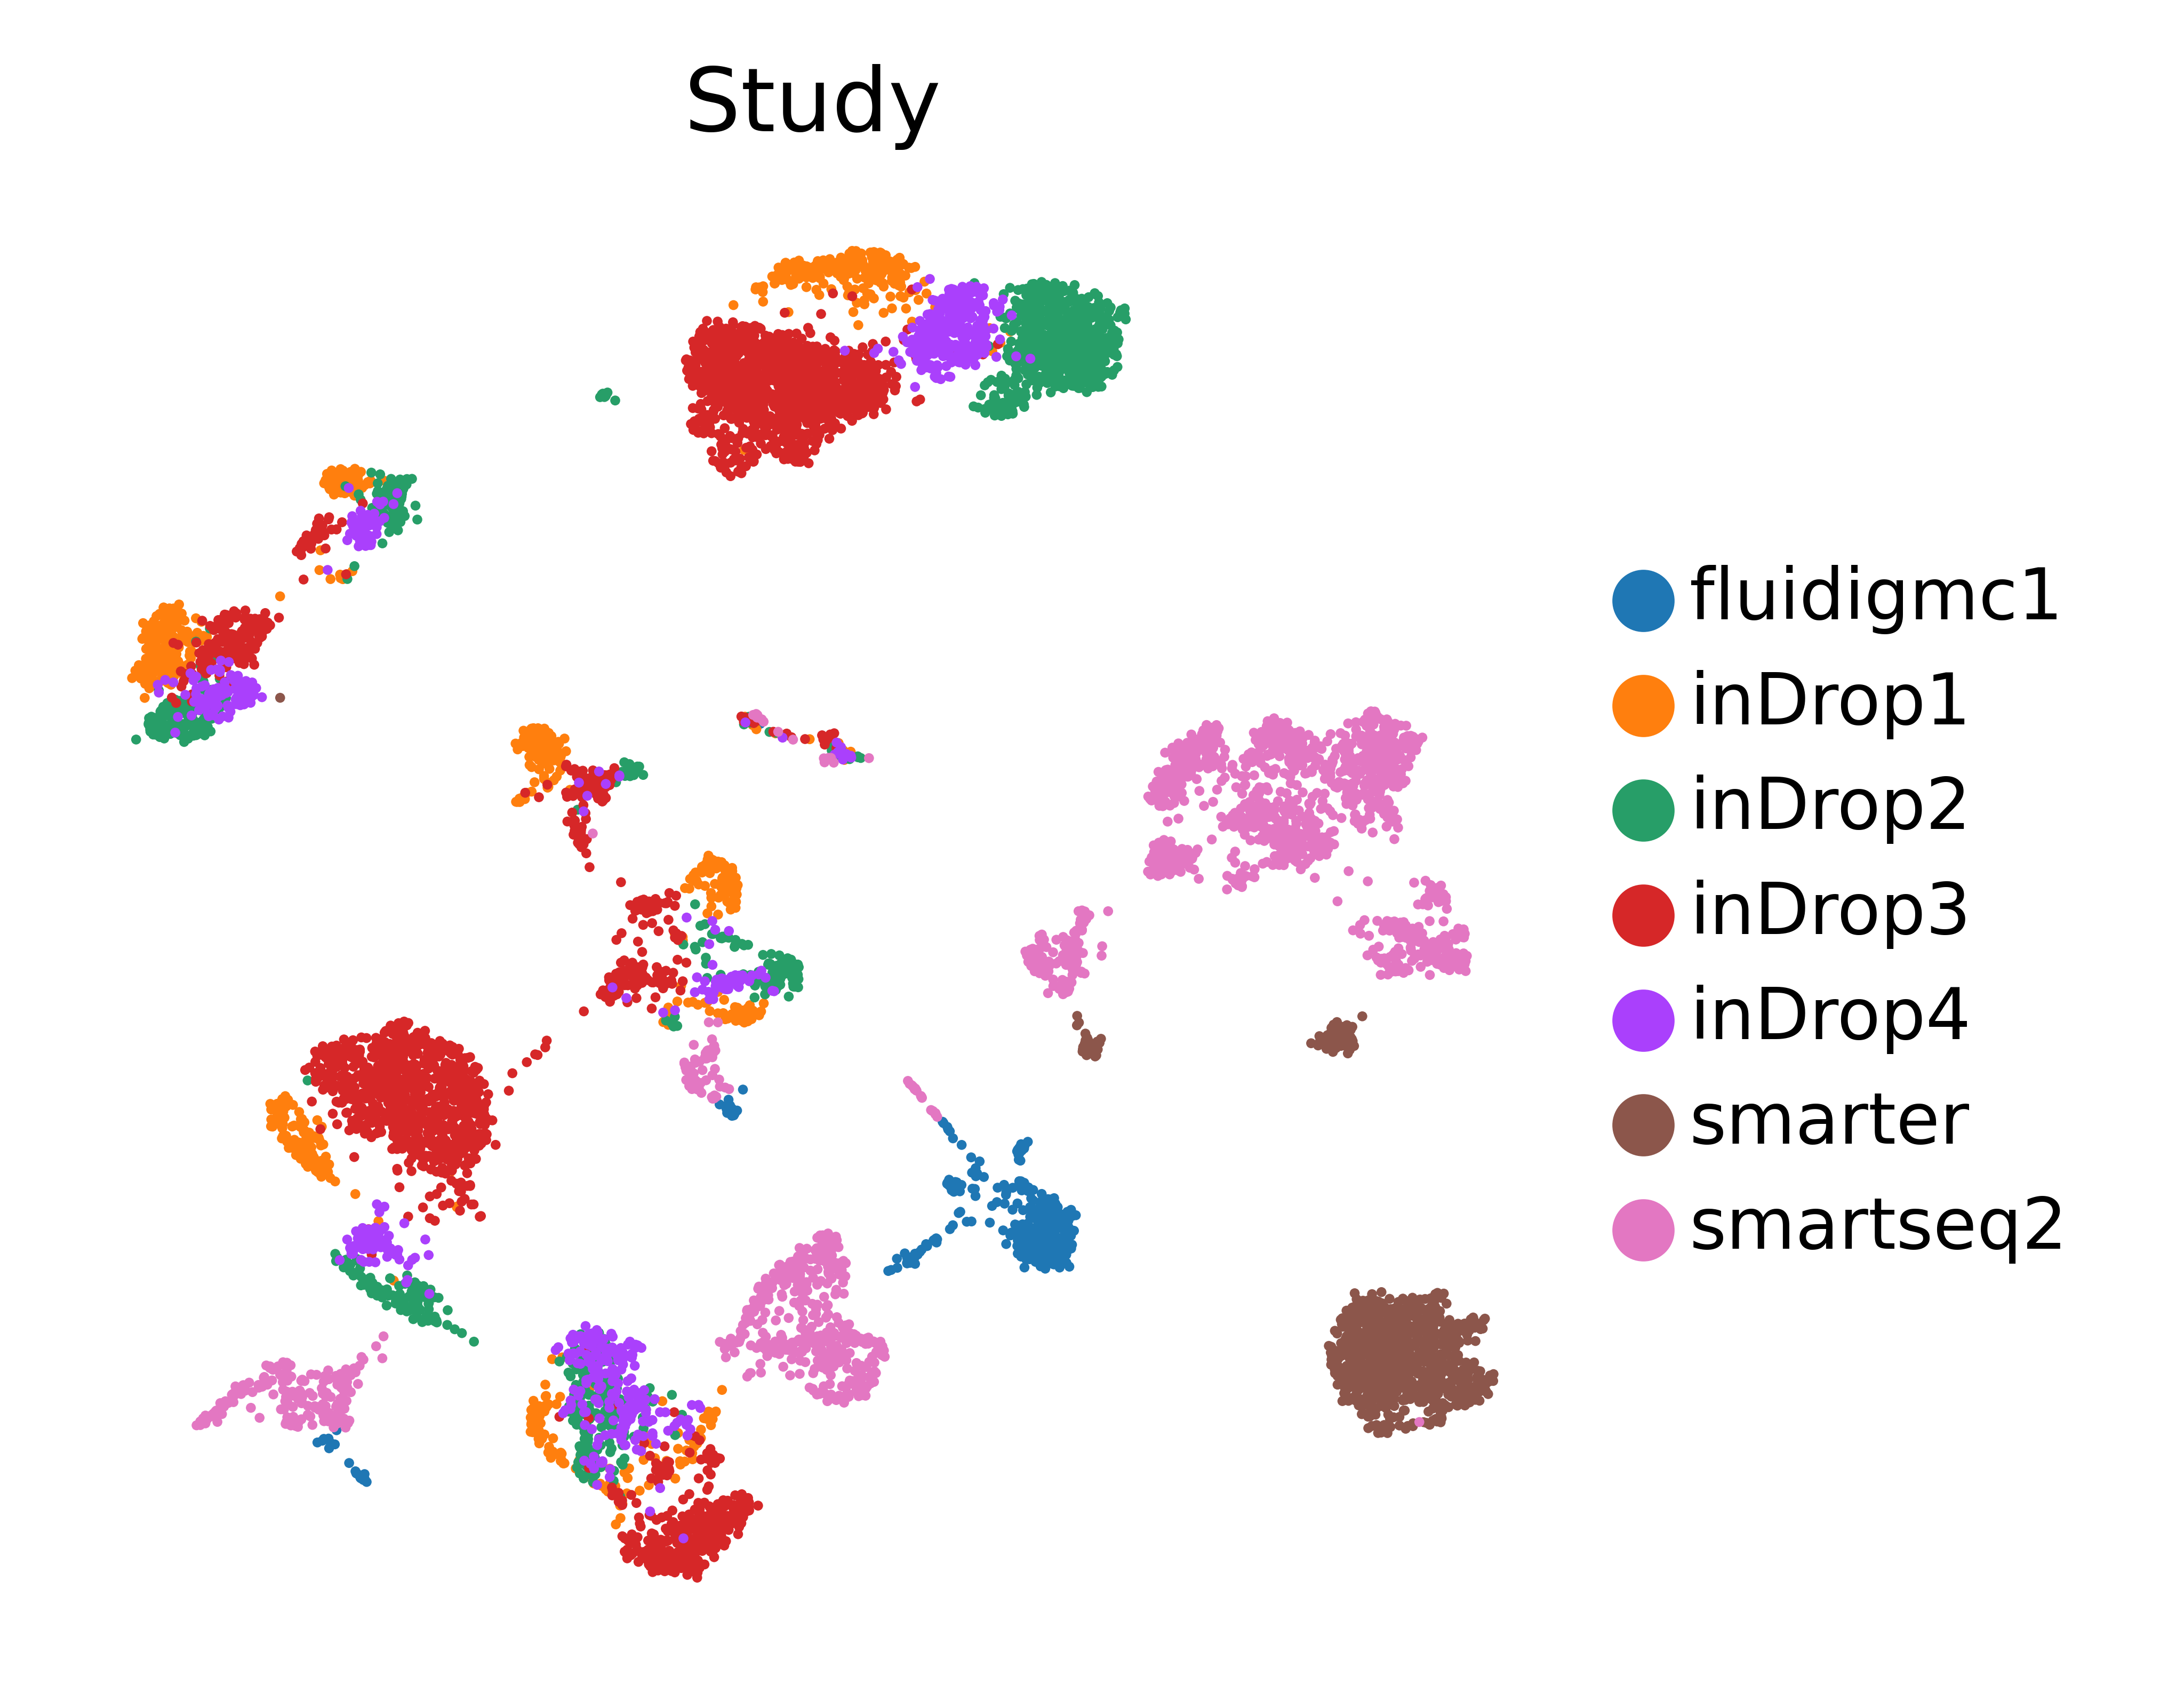

In [192]:
plt.rcParams['legend.fontsize'] = 8
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(adata_plot, color='study', size=5, frameon=False, show=False, ax=ax, alpha=1)
ax.set_title('Study', fontsize=10)
fig.savefig('figure1/umap_study.png', dpi=600, bbox_inches='tight')
#sc.pl.umap(adata_plot[adata_plot.obs['cell_type']=='beta'], size=15, color='cell_type', frameon=False, show=False, ax=ax)

# Supervised Reference Training (100% labels used)

In [25]:
lataq_ref = EMBEDCVAE(
    adata=ref_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_keys,
    hidden_layer_sizes=[128, 128, 128],
)

Embedding dictionary:
 	Num conditions: 7
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [38]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_landmark_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}


In [ ]:

lataq_ref.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=400,
    alpha_epoch_anneal=1e6,
    eta=10,
    clustering_res=2,
)

In [29]:
lataq_ref = EMBEDCVAE.load('pancreas/', ref_adata)

AnnData object with n_obs × n_vars = 9530 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'batch', 'query'
    obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
Embedding dictionary:
 	Num conditions: 7
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [ ]:
lataq_ref.save('pancreas/')

In [32]:
data_latent = lataq_ref.get_latent(
    ref_adata.X, 
    ref_adata.obs[condition_key].values
)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs = ref_adata.obs.copy()
sc.pp.neighbors(adata_latent, n_neighbors=10)
sc.tl.umap(adata_latent)

... storing 'study' as categorical
... storing 'cell_type' as categorical
... storing 'pred_label' as categorical


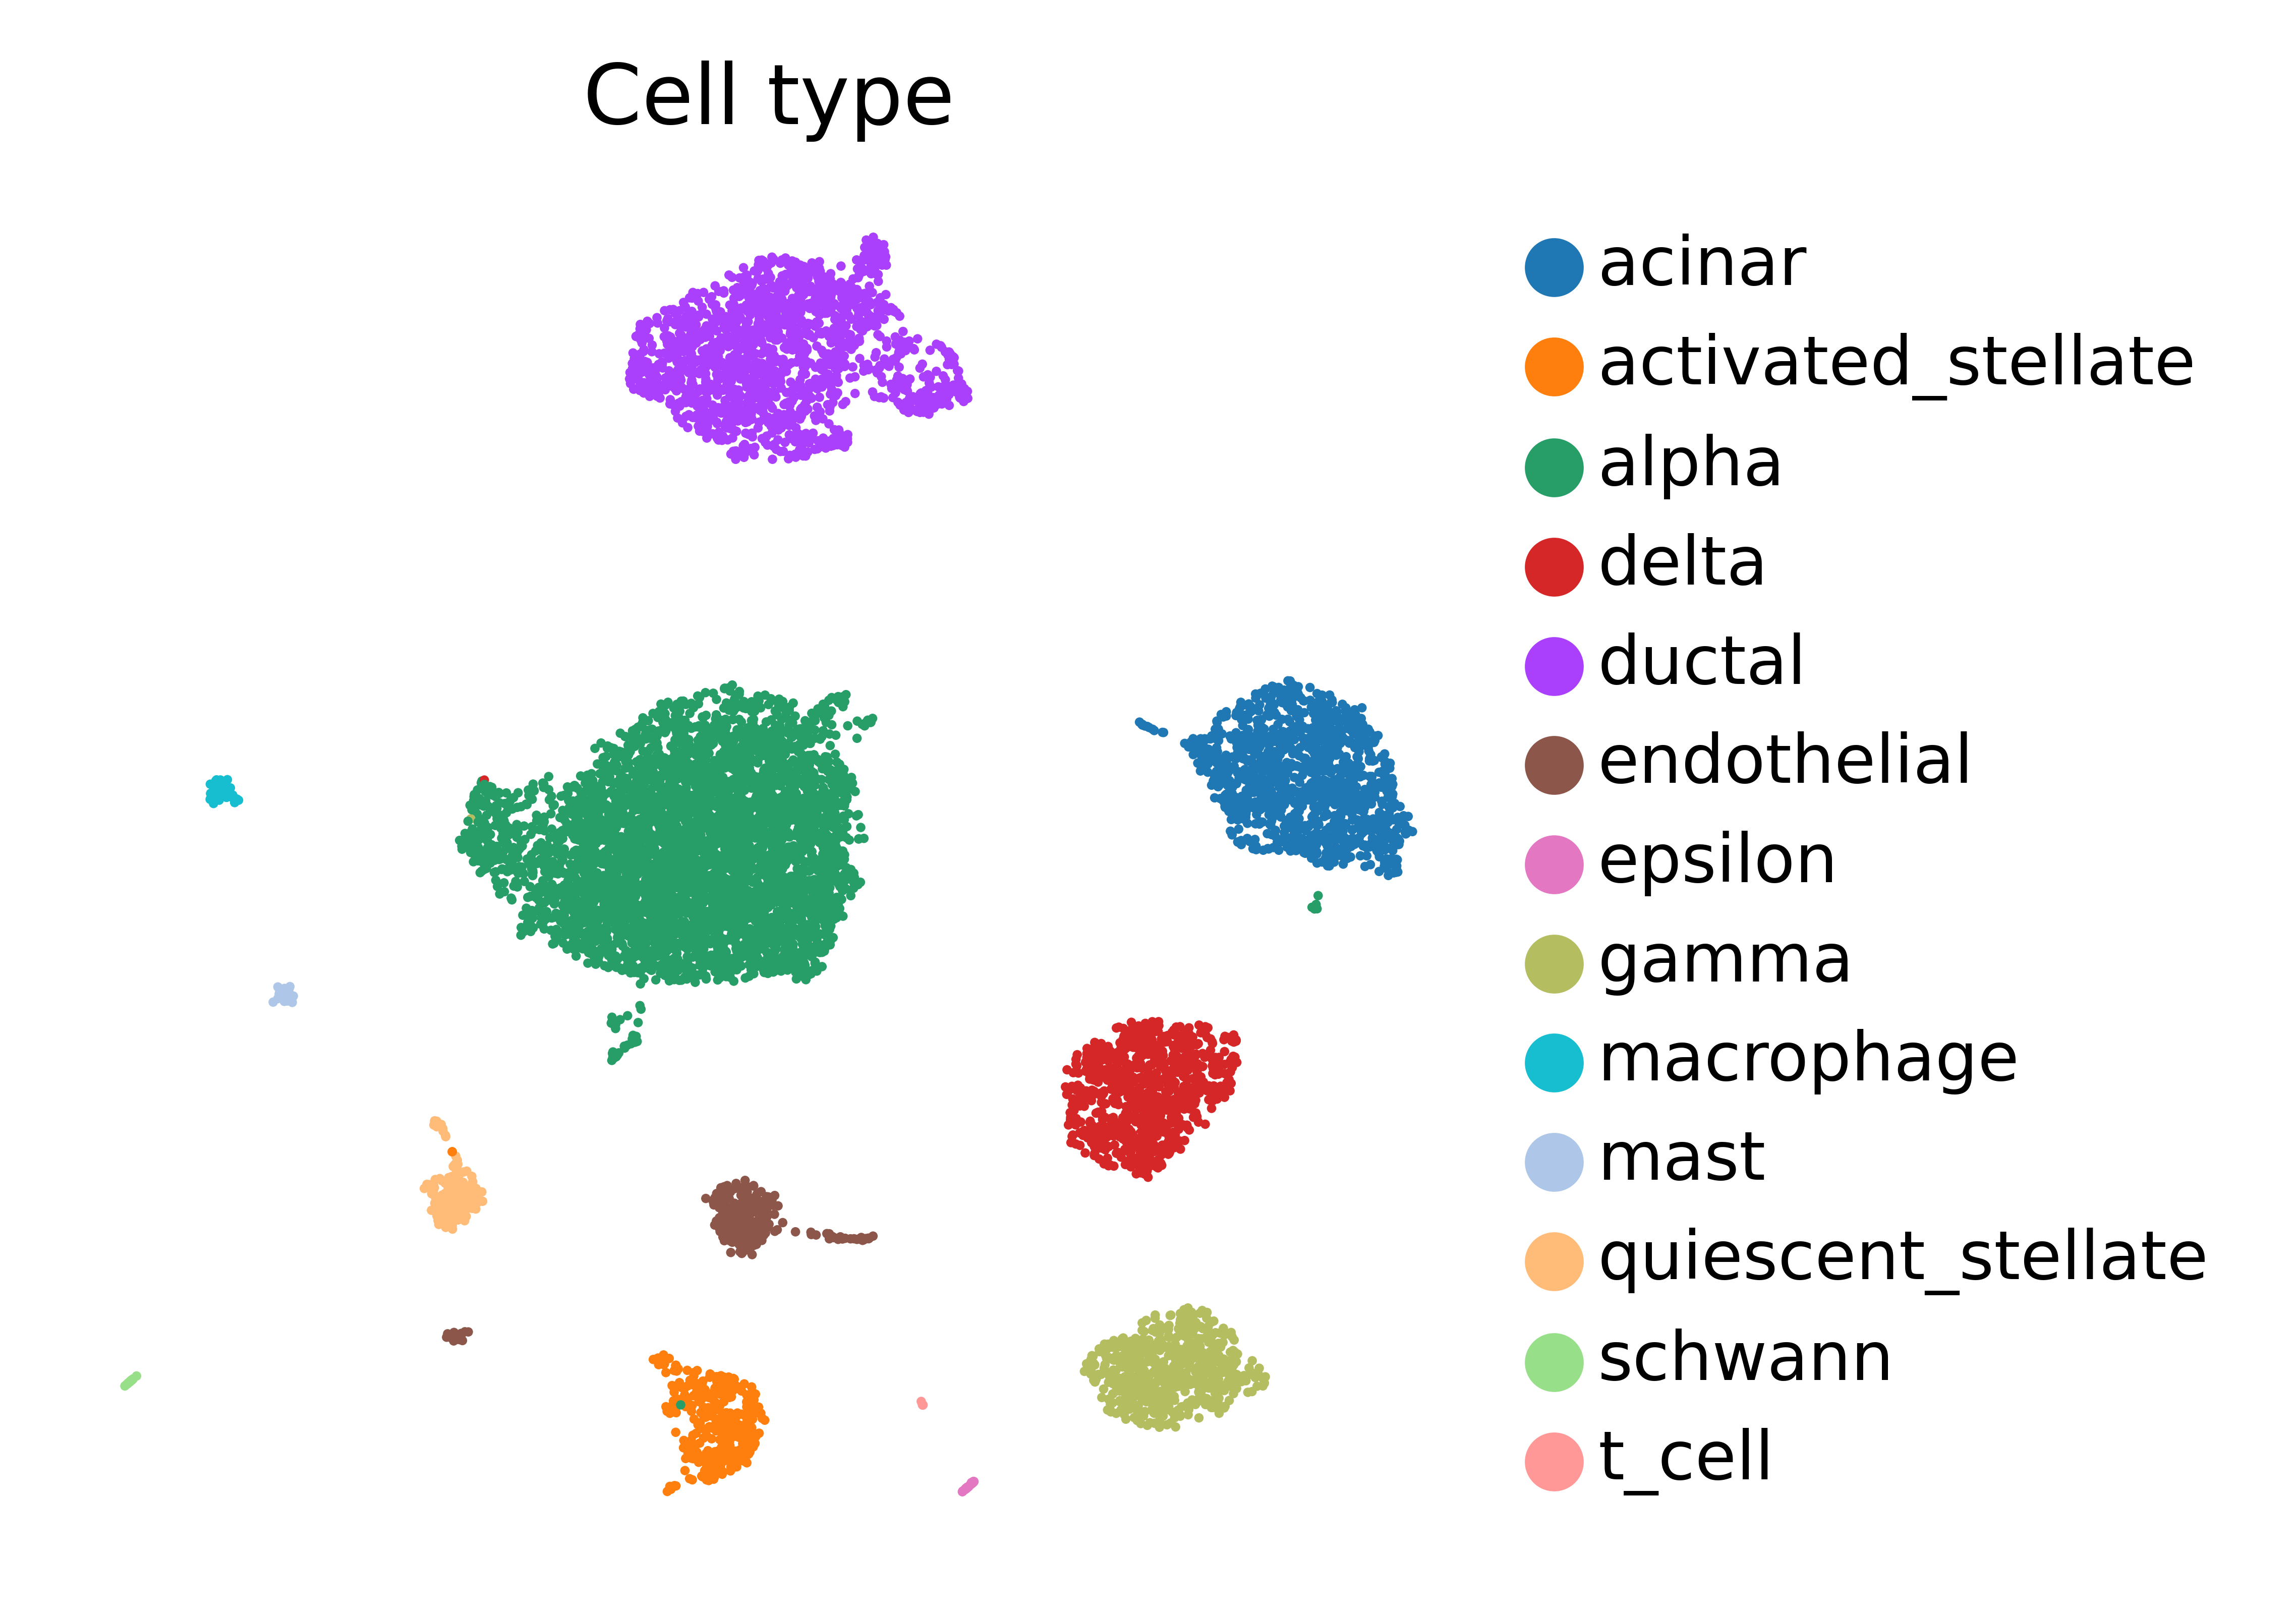

In [33]:
plt.rcParams['legend.fontsize'] = 8
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(adata_latent, color='cell_type', size=5, frameon=False, show=False, ax=ax, alpha=1)
ax.set_title('Cell type', fontsize=10)
fig.savefig('figure1/umap_latent_ct.png', dpi=600, bbox_inches='tight')


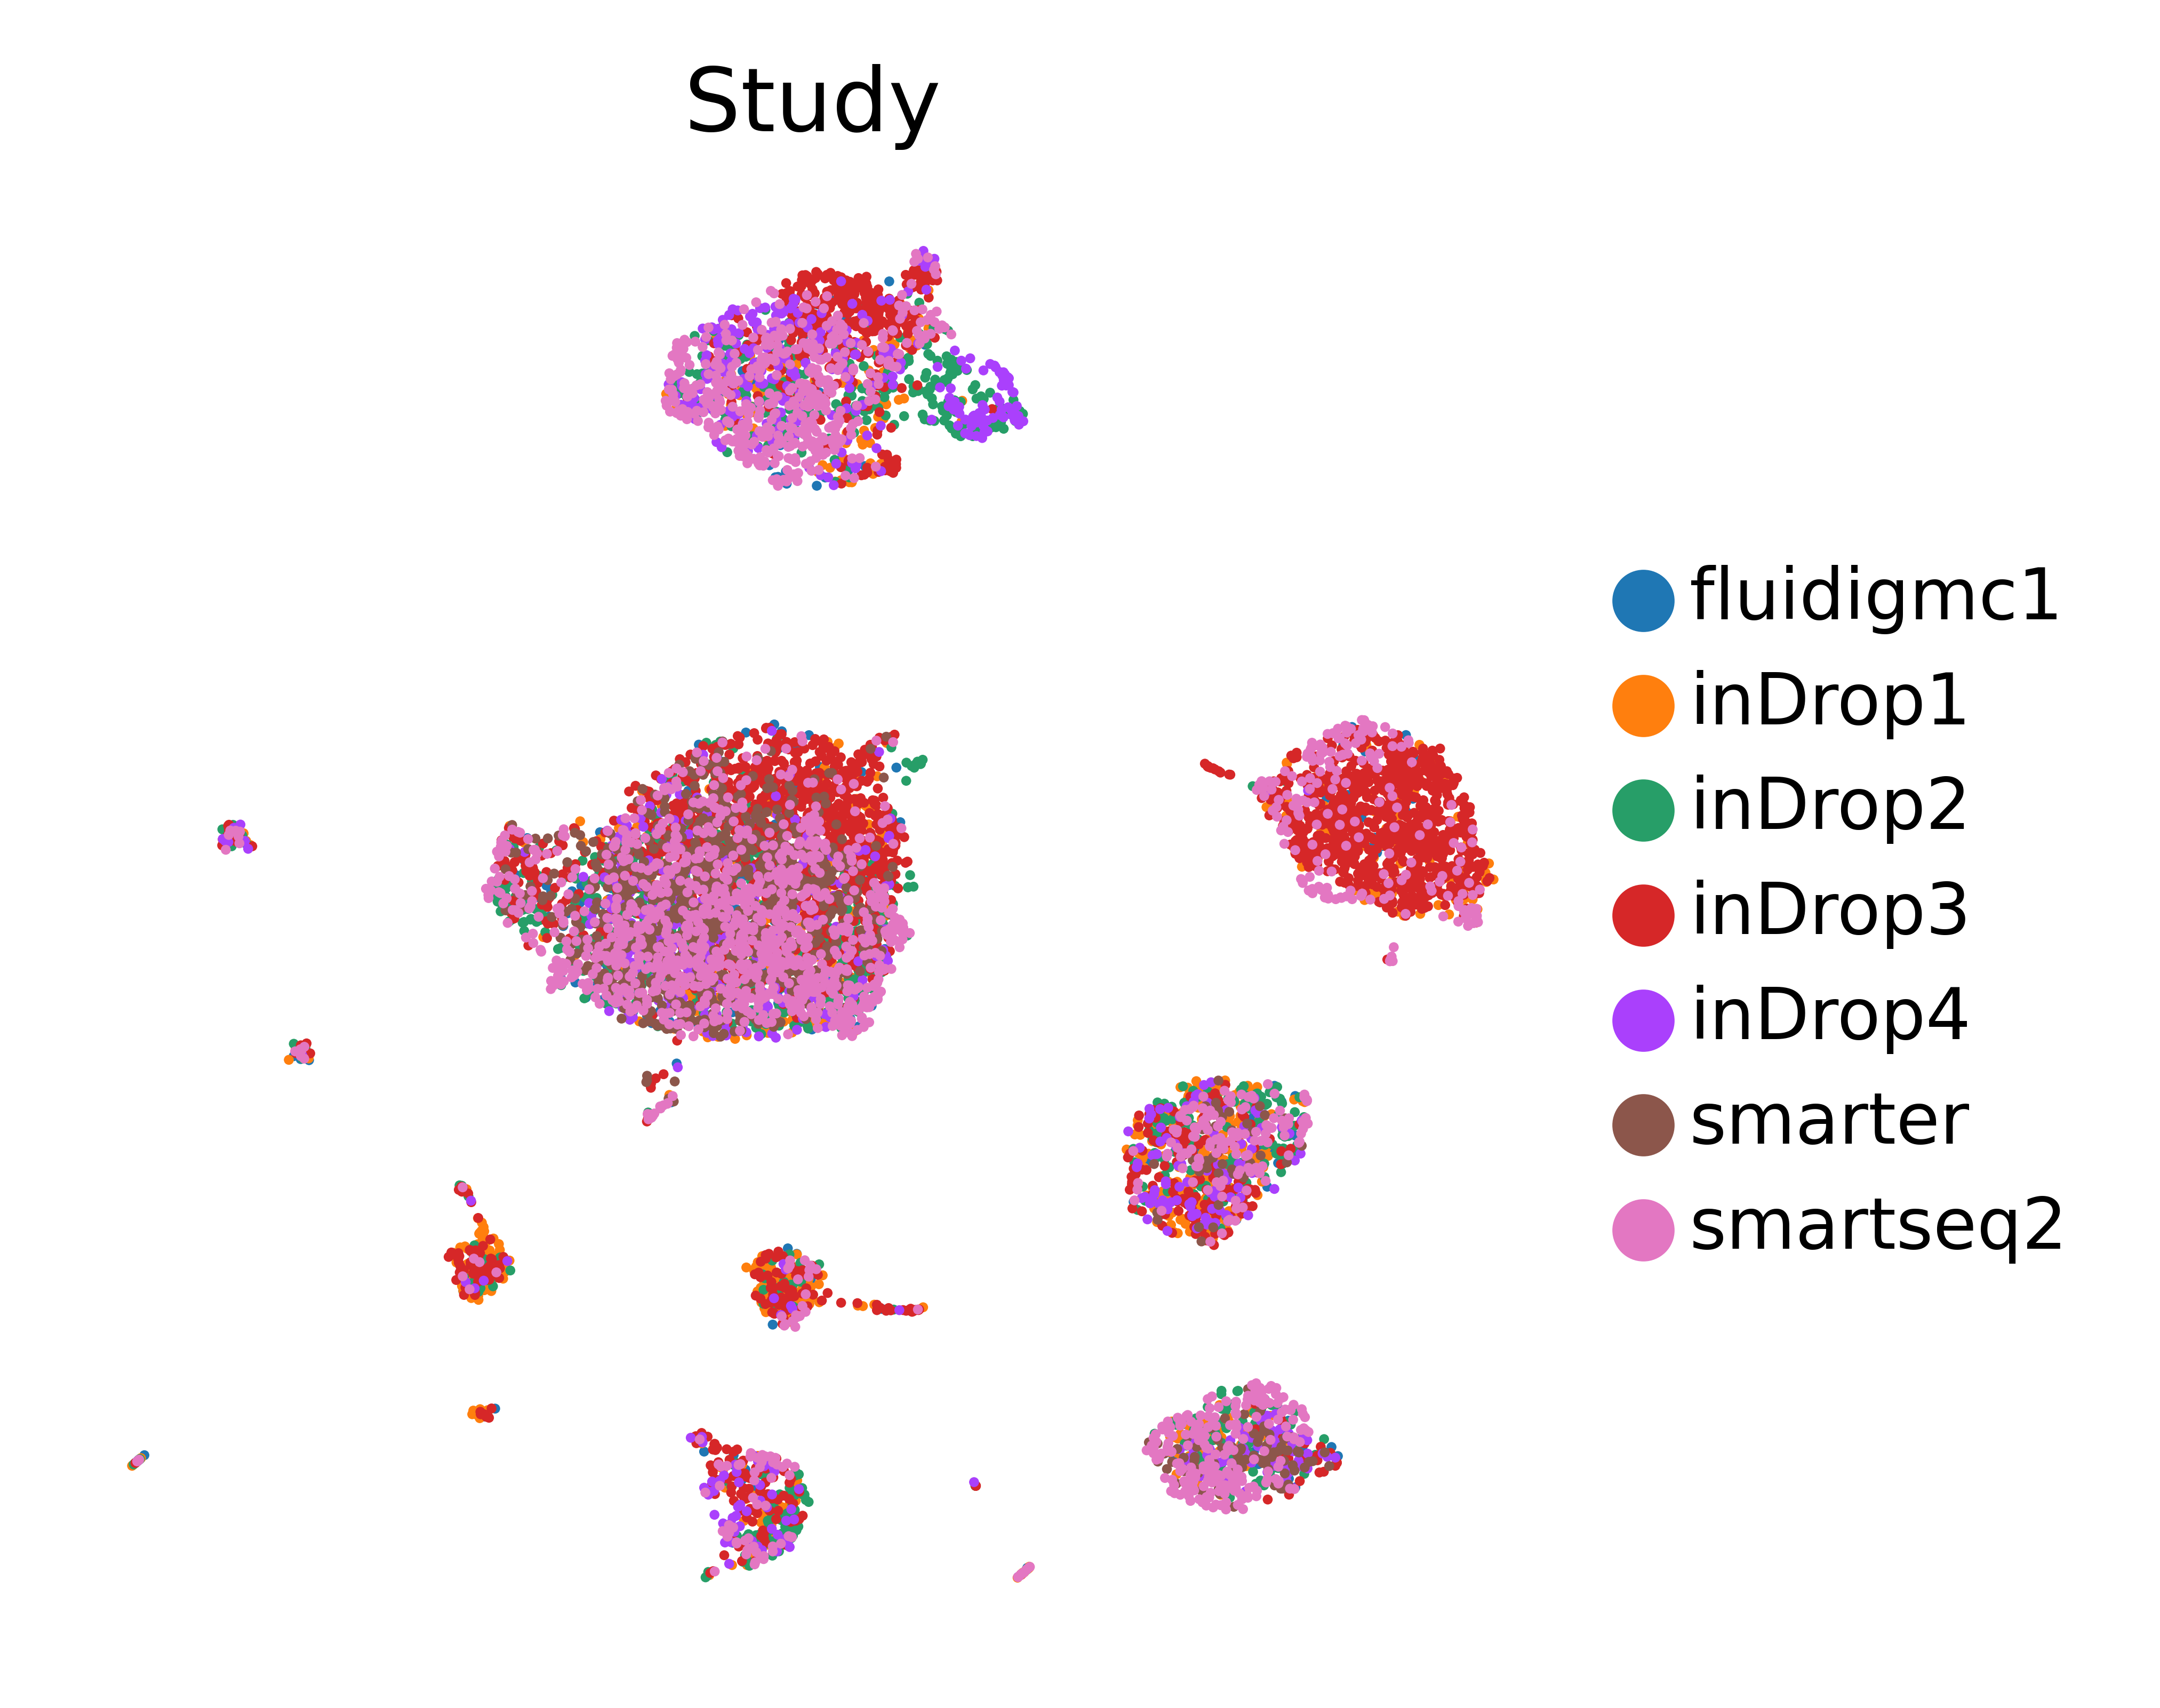

In [35]:
plt.rcParams['legend.fontsize'] = 8
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(adata_latent, color='study', size=5, frameon=False, show=False, ax=ax, alpha=1)
ax.set_title('Study', fontsize=10)
fig.savefig('figure1/umap_latent_study.png', dpi=600, bbox_inches='tight')


# Unsupervised Query Training (0 labels used)

In [83]:
lataq = EMBEDCVAE.load_query_data(
    adata=query_adata,
    reference_model='pancreas_wquery',
    labeled_indices=[]
)

AnnData object with n_obs × n_vars = 3289 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'batch', 'query'
    obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
Embedding dictionary:
 	Num conditions: 9
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 

9


In [84]:
lataq.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=400,
    eta=0,
    clustering_res=2,
)

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
loaders init
loaders init done
0.025841712951660156
 |████████████████----| 80.0%  - val_loss: 1781.9850260417 - val_trvae_loss: 1781.9850260417
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 25 clusters.
 |████████████████████| 100.0%  - val_loss: 1779.6307779948 - val_trvae_loss: 1779.6307779948 - val_landmark_loss: 0.0000000000 - val_unlabeled_loss: 0.7166681488
Saving best state of network...
Best State was in Epoch 400


In [85]:
lataq.save(
    'pancreas_wquery',
    overwrite=True
)

In [114]:
results_dict_q = lataq.classify(
    x=adata.X, 
    c=adata.obs[condition_key].values,
    metric="dist",
    get_prob=False,
    threshold=-np.inf
)
preds_q = results_dict_q[cell_type_key]['preds']
probs_q = results_dict_q[cell_type_key]['probs']
probs_log = np.log1p(probs_q)
is_novel = probs_log < 0.05

In [115]:
len(probs_log)

12819

In [129]:
data_latent = lataq.get_latent(
    adata.X, 
    adata.obs[condition_key].values,
    mean=True
)
data_latent_2 = lataq.get_latent(
    adata.X, 
    adata.obs[condition_key].values,
    mean=True
)

In [130]:
np.allclose(data_latent, data_latent_2)

True

In [183]:
lataq.model.eval()
data_latent = lataq.get_latent(
    adata.X, 
    adata.obs[condition_key].values,
    mean=True
)

adata_latent = sc.AnnData(data_latent)
adata_latent.obs = adata.obs.copy()

adata_latent.obs[f'{cell_type_key}_pred'] = preds_q.tolist()
adata_latent.obs[f'{cell_type_key}_prob'] = probs_q.tolist()
adata_latent.obs['probs_ct_log'] = probs_log
adata_latent.obs[f'{cell_type_key}_pred'][adata_latent.obs['probs_ct_log'] > 0.06] = 'unknown'
adata_latent.obs[f'classifier_outcome'] = (
    adata_latent.obs[f'{cell_type_key}_pred'] == adata_latent.obs[f'{cell_type_key}']
)
adata_latent.obs['classifier_outcome'] = adata_latent.obs['classifier_outcome'].astype(str)
adata_latent.obs['classifier_outcome'][adata_latent.obs['cell_type_pred']=='unknown'] = 'unknown'
sc.pp.neighbors(adata_latent, n_neighbors=10)
sc.tl.umap(adata_latent)

<ipython-input-183-8138477ddfd1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_latent.obs[f'{cell_type_key}_pred'][adata_latent.obs['probs_ct_log'] > 0.06] = 'unknown'
<ipython-input-183-8138477ddfd1>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_latent.obs['classifier_outcome'][adata_latent.obs['cell_type_pred']=='unknown'] = 'unknown'


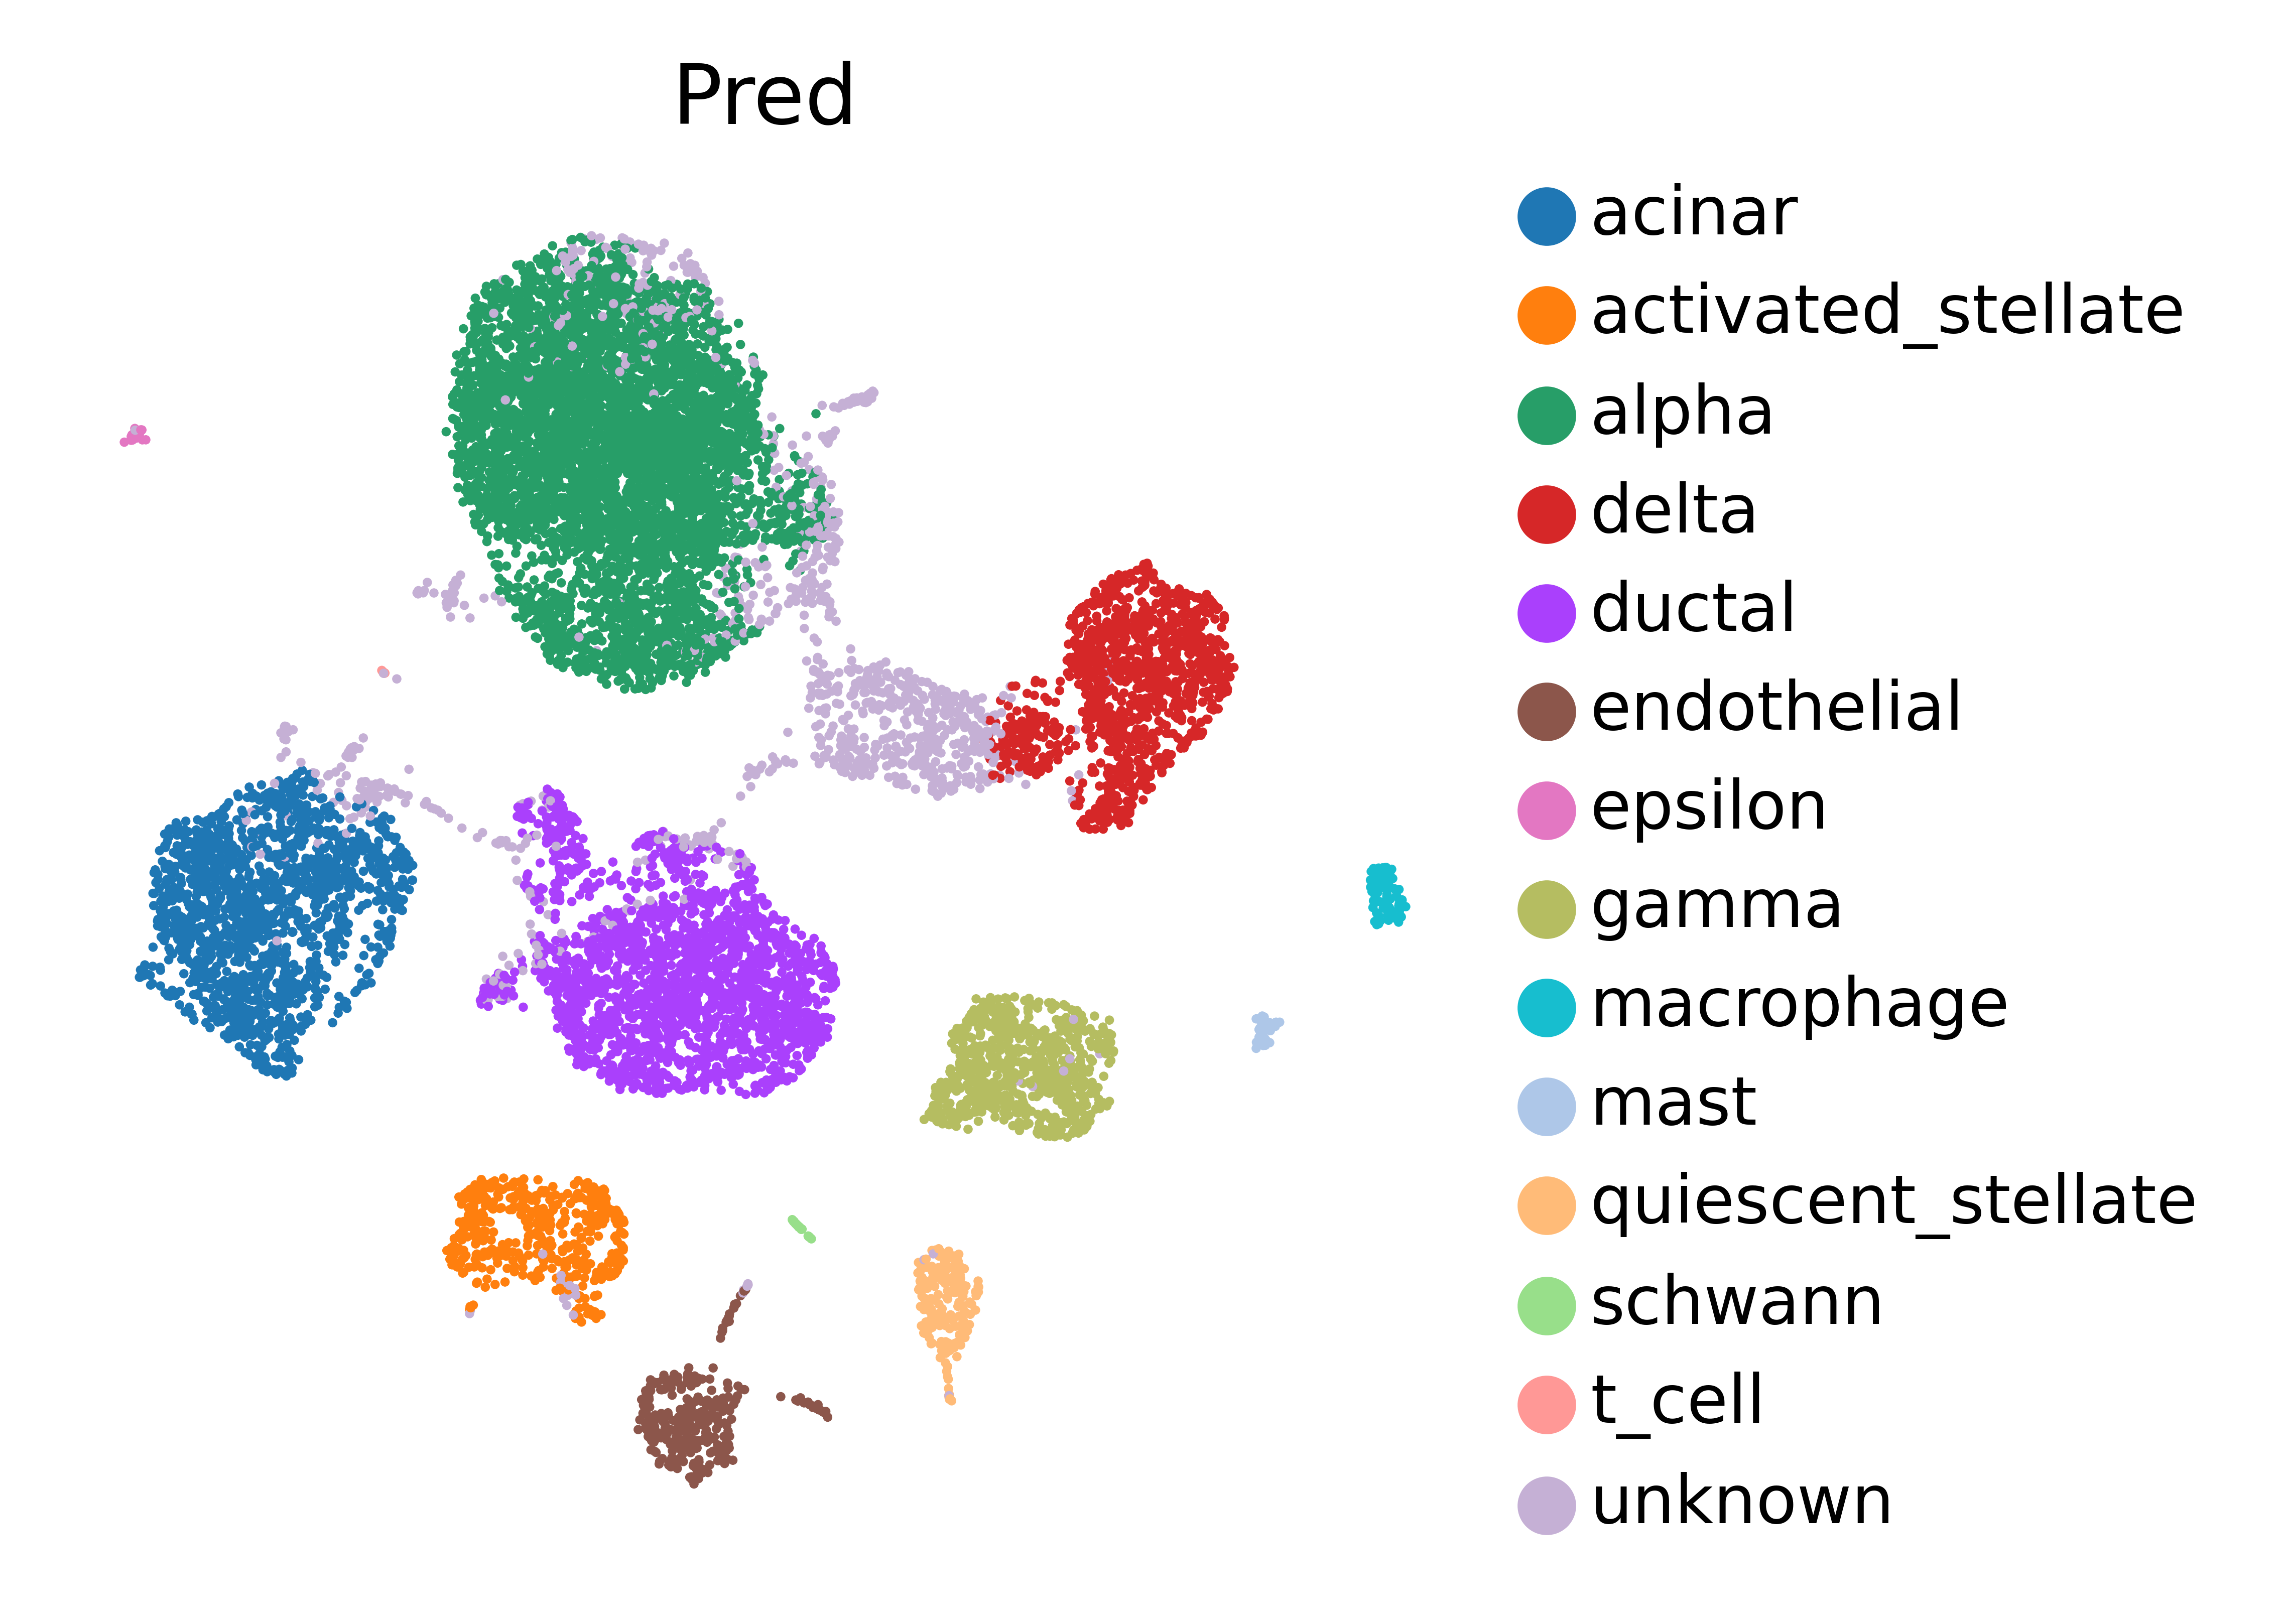

In [201]:
plt.rcParams['legend.fontsize'] = 8
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(
    adata_latent,
    color='cell_type_pred', 
    size=5,
    frameon=False, 
    show=False, 
    ax=ax, 
    palette=palette_ct,
    alpha=1
)
ax.set_title('Pred', fontsize=10)
fig.savefig('figure1/umap_latent_wquery_pred.png', dpi=600, bbox_inches='tight')


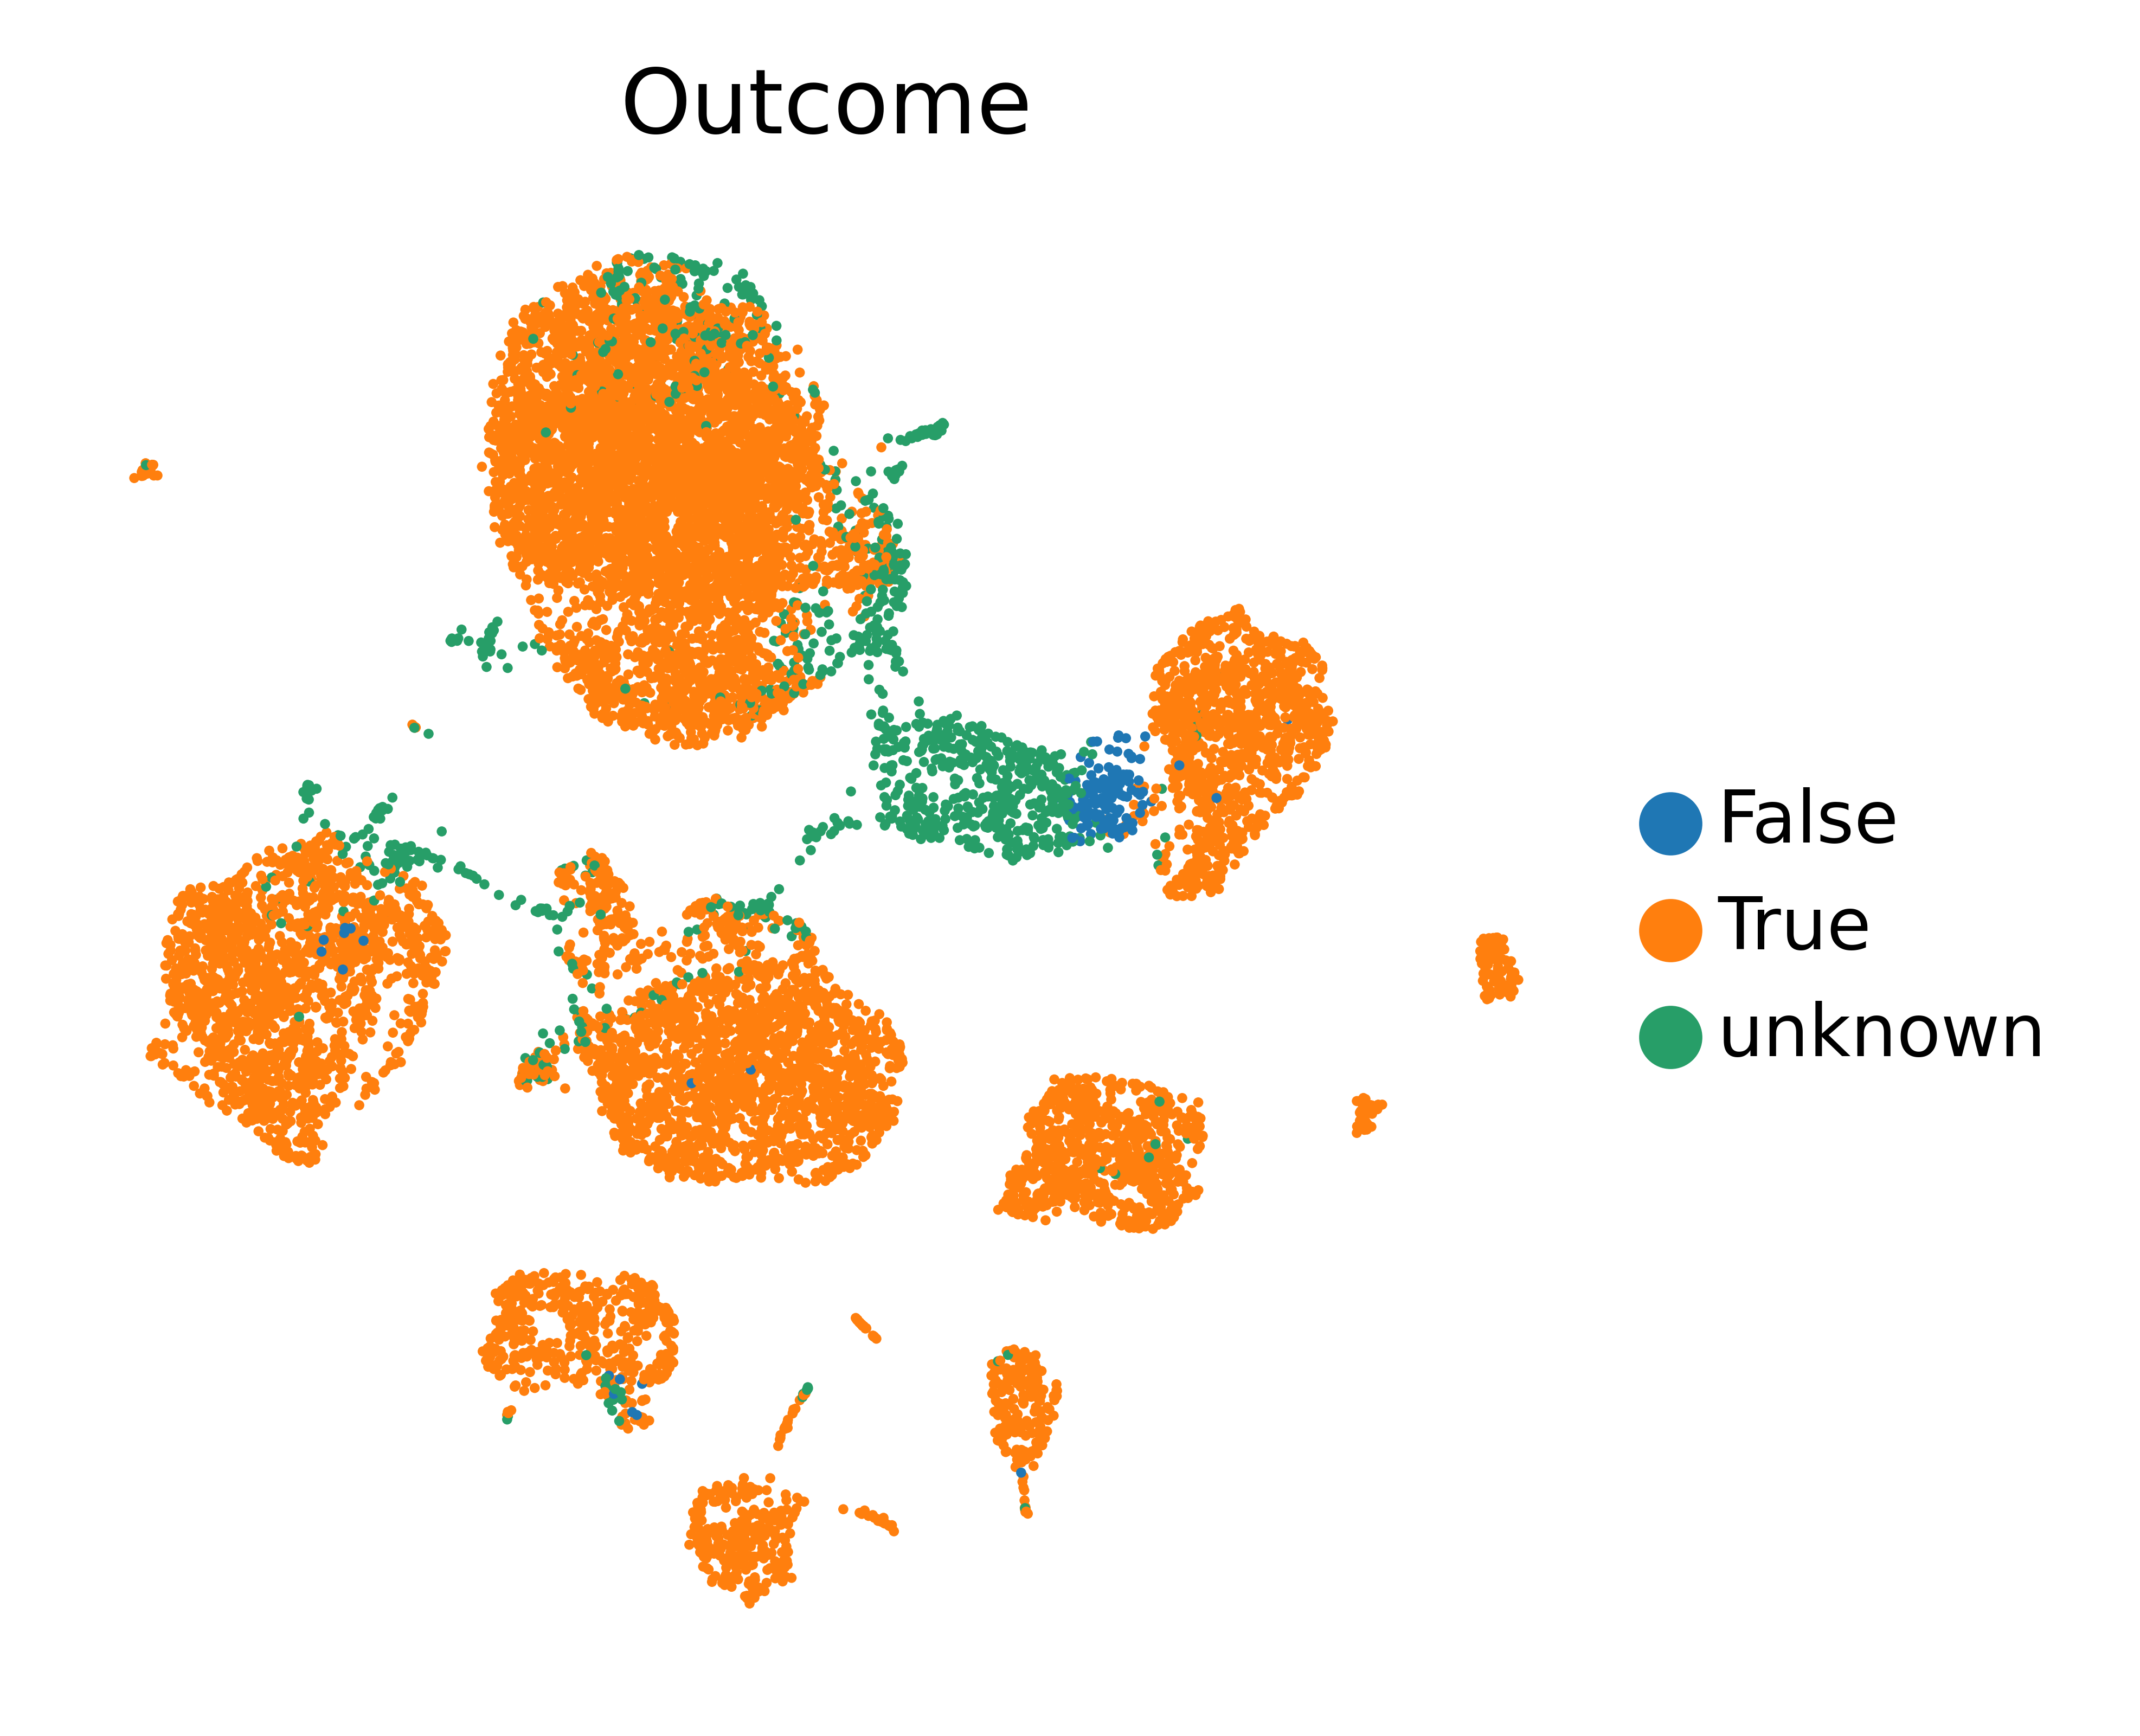

In [187]:
plt.rcParams['legend.fontsize'] = 8
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(adata_latent, color='classifier_outcome', size=5, frameon=False, show=False, ax=ax, alpha=1)
ax.set_title('Outcome', fontsize=10)
fig.savefig('figure1/umap_latent_wquery_outcome.png', dpi=600, bbox_inches='tight')


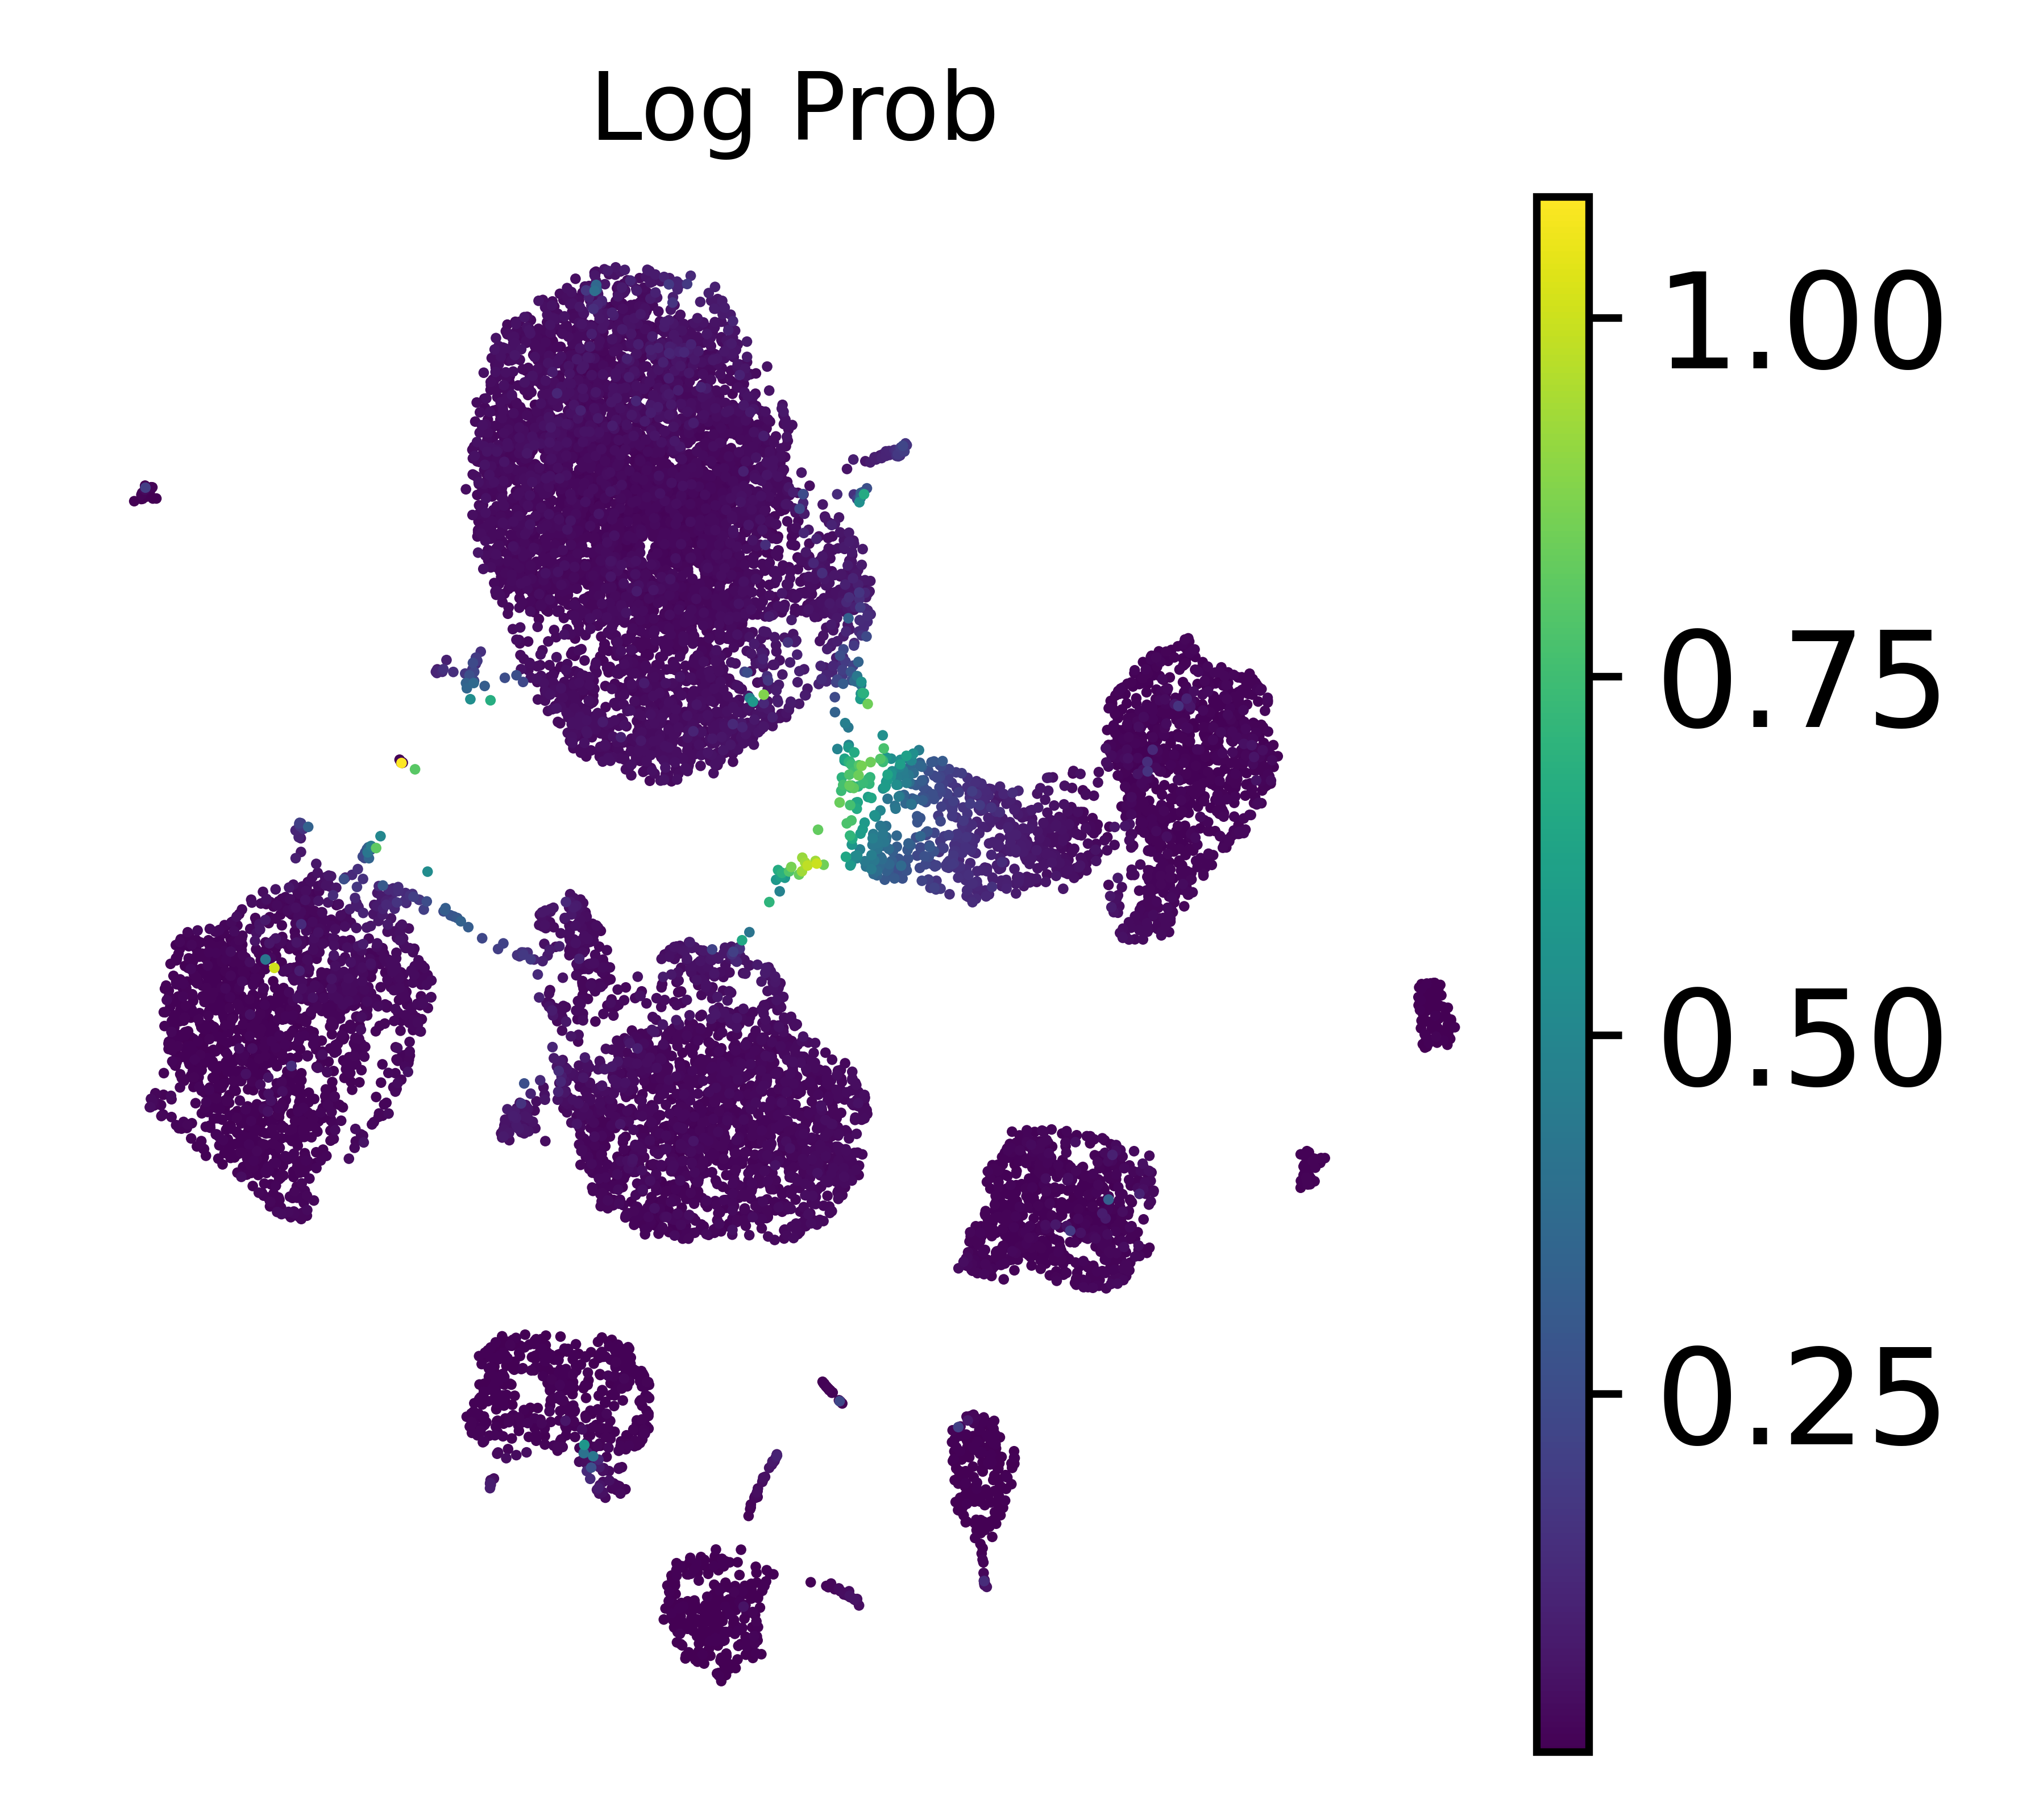

In [188]:
plt.rcParams['legend.fontsize'] = 8
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(adata_latent, color='probs_ct_log', size=5, frameon=False, show=False, ax=ax, alpha=1)
ax.set_title('Log Prob', fontsize=10)
fig.savefig('figure1/umap_latent_wquery_logprob.png', dpi=600, bbox_inches='tight')


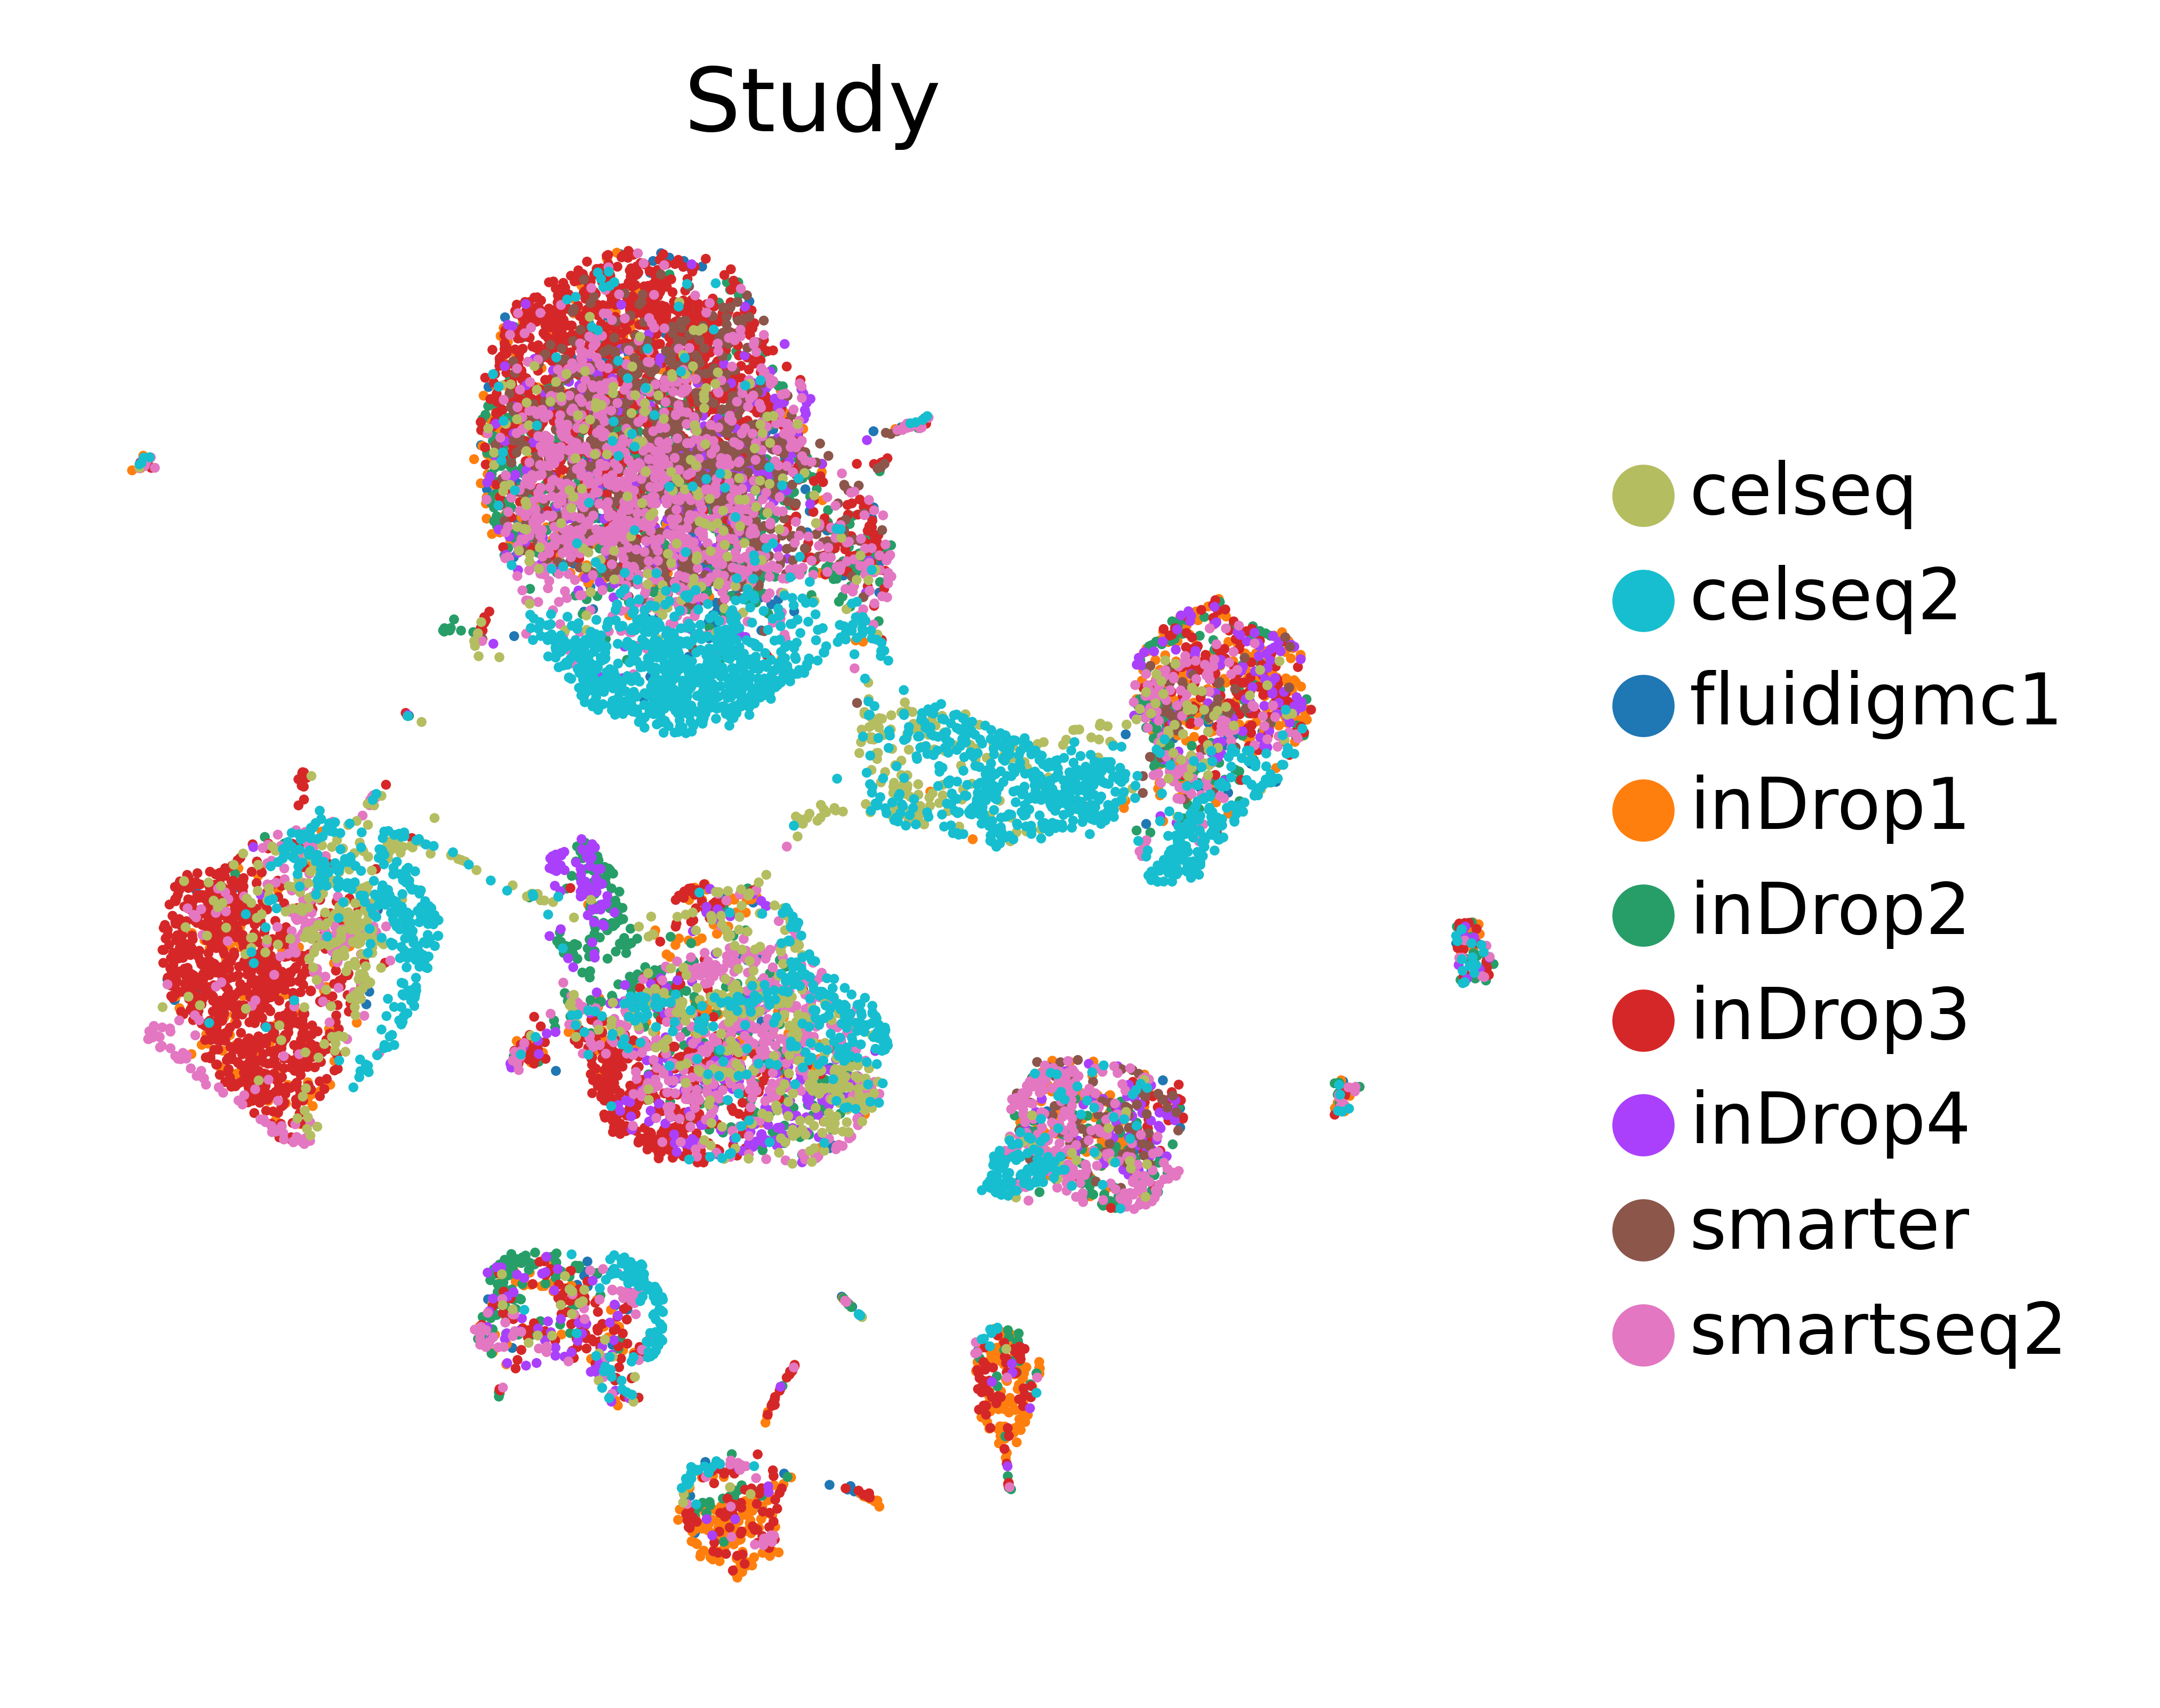

In [202]:
plt.rcParams['legend.fontsize'] = 8
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(
    adata_latent,
    color='study',
    size=5, 
    frameon=False, 
    show=False, 
    palette=palette_study,
    ax=ax, 
    alpha=1
)
ax.set_title('Study', fontsize=10)
fig.savefig('figure1/umap_latent_wquery_study.png', dpi=600, bbox_inches='tight')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


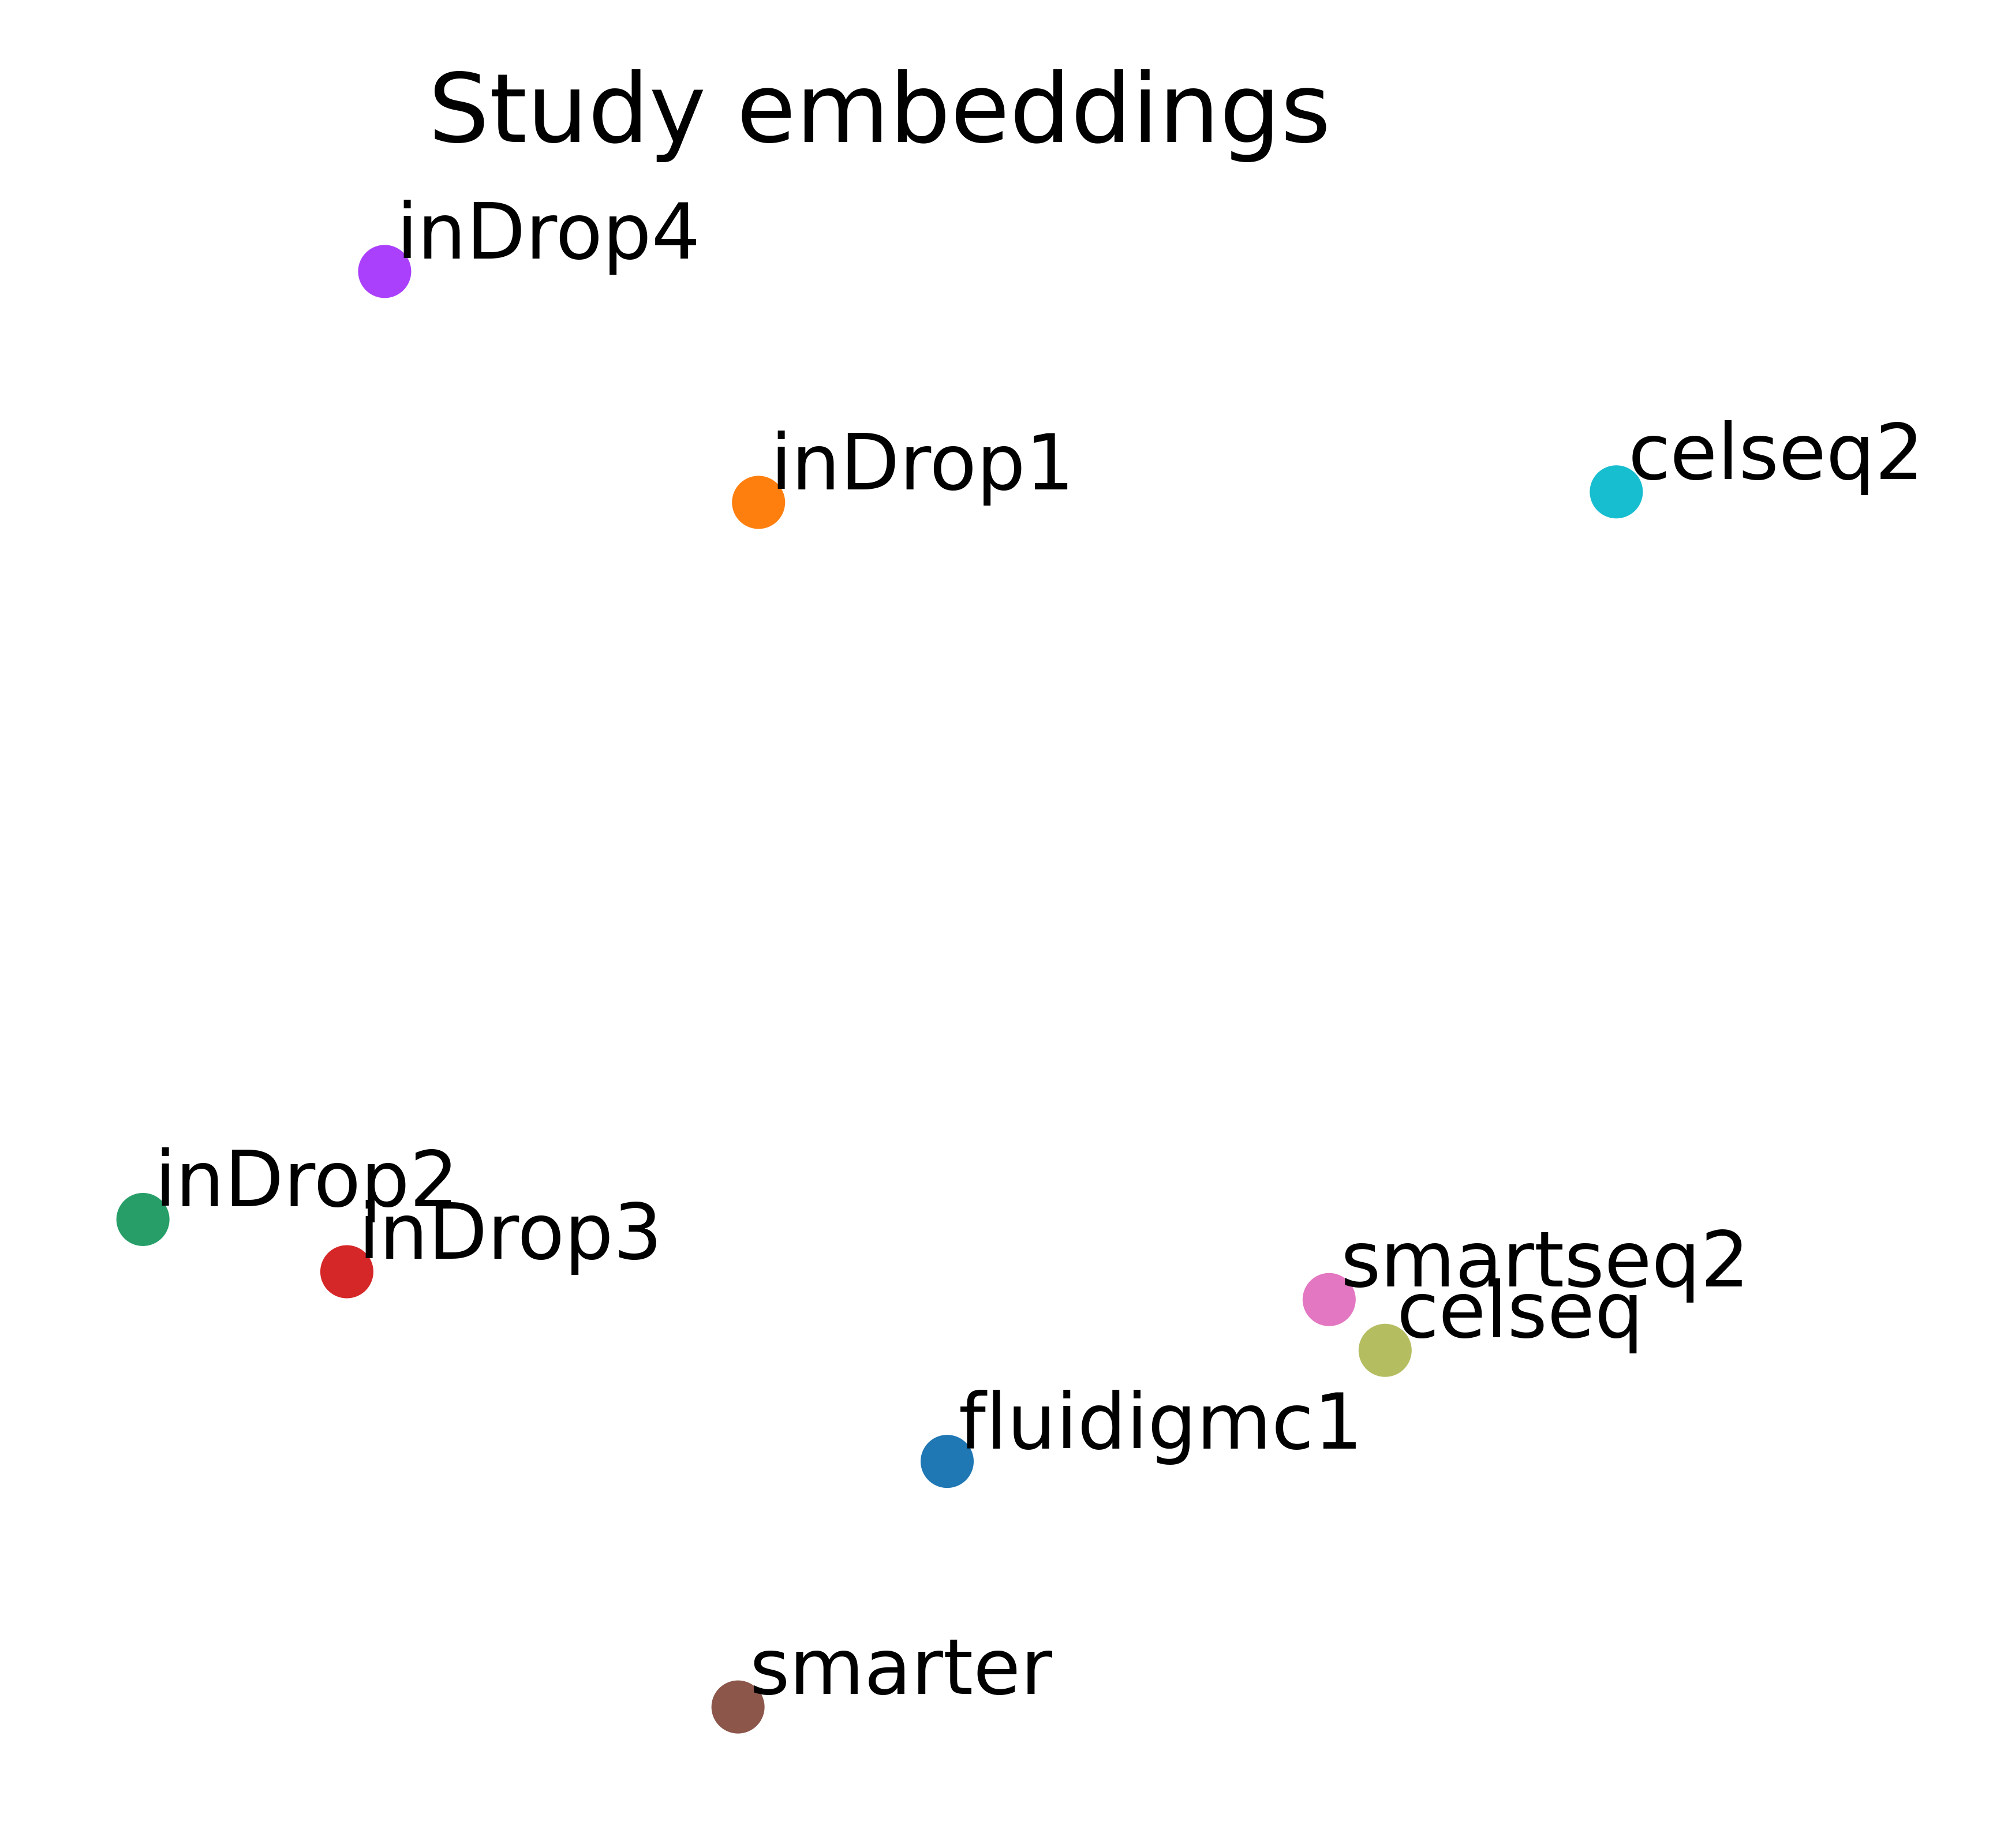

In [203]:
from sklearn.decomposition import KernelPCA


embedding = lataq.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=5, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = lataq.conditions_

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 0], 
    emb_pca[:, 1], 
    cond,
    hue_order=cond,
    #palette = 'Reds',
    ax=ax
)

for i in range(emb_pca.shape[0]):
    ax.text(
        x=emb_pca[i, 0]+0.01,
        y=emb_pca[i, 1]+0.01,
        s=cond[i],
        fontsize=8
    )
ax.grid(False)
ax.set_title('Study embeddings', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
ax.get_legend().remove()
fig.savefig('figure1/study_emb.png', dpi=600, bbox_inches='tight')